# TFM: Predicción de Tiempos de Producción mediante Aprendizaje Automático

**Autor:** Stephan Richter  
**Tutora:** Lorena Polo Navarro  
**Universidad:** UOC - Máster en Ciencia de Datos  
**Fecha:** Diciembre 2025

---

## Notebook 2b/3: Entrenamiento y Calibración de Modelos Plegado

Este notebook entrena modelos predictivos con datos sintéticos de plegados generados por TruTops Calculate 
y los calibra contra datos reales de producción.

**Contenido:**
1. Carga de datos sintéticos y reales
2. Preprocesamiento y feature engineering
3. Eliminación de outliers (IQR)
4. Entrenamiento de modelos con datos sintéticos
5. Calibración PRE-entrenamiento
6. Exportación de modelos calibrados

## Diseño Experimental
```
DATOS SINTETICOS (100%)
    - Eliminar outliers (IQR)
    --> ENTRENAMIENTO del modelo

DATOS REALES
    - Eliminar donde tiempo_nominal == tiempo_real
    - Eliminar outliers (IQR)
    
    Split Datos Reales (Calibracion-Prediccion):
    |-- 50% --> CALIBRACION (calcular factor)
    |-- 50% --> TEST (evaluacion final, NUNCA visto)
```

**Justificación PRE-calibración:** El Experimento 6 demostró que transformar los datos 
sintéticos ANTES del entrenamiento (PRE) supera en un 23% a ajustar las predicciones 
DESPUÉS (POST).

## 1. Importaciones y Configuración

In [11]:
# =============================================================================
# 1. IMPORTACIONES Y CONFIGURACION
# =============================================================================

# Manipulación de datos
import pandas as pd
import numpy as np
from pathlib import Path

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

# Utilidades
import joblib
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Rutas
DATA_PATH = Path('datos_procesados')
OUTPUT_PATH = Path('modelos')
OUTPUT_PATH.mkdir(exist_ok=True)

print("=" * 60)
print("CONFIGURACION")
print("=" * 60)
print(f"Random State: {RANDOM_STATE}")
print(f"Datos: {DATA_PATH}")
print(f"Modelos: {OUTPUT_PATH}")

CONFIGURACION
Random State: 42
Datos: datos_procesados
Modelos: modelos


## 2. Configuracion de Parametros

Centralizacion de rutas, columnas y parametros para facilitar ajustes y reproducibilidad.

In [12]:
# =============================================================================
# 2. CONFIGURACION DE PARAMETROS
# =============================================================================

# --- Rutas de datos ---
PATH_REAL = Path('datos_procesados/df_real_plegado.csv')
PATH_SINTETICO = Path('datos_sinteticos/df_sintetico_laser_plegado.csv')

# --- Columnas DATOS REALES ---
COL_MATERIAL_REAL = 'MaterialTruTops'
COL_TIEMPO_REAL = 'Tiempo_unitario_real_min'
COL_TIEMPO_NOMINAL = 'Tiempo_unitario_nominal_min'
COL_TIEMPO_REAL_ORIGINAL = 'Tiempo de mecanizado real [min]'


# --- Columnas DATOS SINTETICOS ---
COL_MATERIAL_SINT = 'material_name'
COL_TIEMPO_SINT = 'bend_v3_time_per_part_min'

# --- Parametros de limpieza ---
TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL = 0  # Minutos a restar de sinteticos
IQR_FACTOR = 1.5            # Factor para deteccion de outliers
MIN_REGISTROS_MATERIAL = 6  # Minimo de registros reales por material

# --- Split de datos reales ---
CALIBRACION_SIZE = 0.5  # 60% para calibracion
TEST_SIZE = 0.5         # 40% para test

# --- Features para modelado ---
FEATURES_REAL = [
    'Anchura', 
    'Longitud', 
    'bounding_box_area_mm2', 
    'aspect_ratio', 
    'perimetro_aproximado_mm',
    'Cantidad real',
    'Peso por unidad'
]

FEATURES_SINT = [
    'part_dimensions_x_mm', 
    'part_dimensions_y_mm', 
    'part_area_mm2', 
    'aspect_ratio', 
    'perimetro',
    'bend_v3_part_qty',
    'part_weight_kg',
    'bend_v3_num_bends'
    
]

# - bend_v3_part_qty: rango [1.00, 792.00], CV=96.8%
#    - bend_v3_num_bends: rango [1.00, 12.00], CV=68.8%
#    - bend_v3_weight_kg: rango [0.00, 239.83], CV=161.6%
#    - bend_v3_length_mm: rango [0.00, 2924.70], CV=69.2%
#    - bend_v3_thickness_mm: rango [0.70, 8.00], CV=70.1%
#    - bend_v3_length_factor: rango [0.90, 2.10], CV=28.1%
#    - bend_v3_thickness_factor: rango [0.90, 1.70], CV=19.7%
#    - bend_v3_complexity_factor: rango [1.00, 1.50], CV=10.8%
#    - bend_v3_quantity_efficiency_pct: rango [-52.00, 50.00], CV=-42.1%
#    - bend_v3_suggested_operators: rango [1.00, 2.00], CV=33.9%
#    - bend_v3_time_per_part_min: rango [0.38, 281.69], CV=142.3%
#    - bend_v3_total_time_min: rango [6.29, 66054.35], CV=192.7%
#    - bend_v3_operator_cost_eur: rango [3.67, 38531.70], CV=192.7%
#    - bend_v3_machine_cost_eur: rango [0.53, 33377.01], CV=210.0%
#    - bend_v3_total_cost_eur: rango [4.22, 71908.71], CV=199.9%
#    - bend_v3_cost_per_part_eur: rango [0.39, 305.84], CV=147.8%

# Mapeo de nombres entre datasets
FEATURE_MAPPING = {
    'Anchura': 'part_dimensions_x_mm',
    'Longitud': 'part_dimensions_y_mm',
    'bounding_box_area_mm2': 'part_area_mm2',
    'aspect_ratio': 'aspect_ratio',
    'perimetro_aproximado_mm': 'perimetro',
    'Cantidad real': 'bend_v3_part_qty',
    'Peso por unidad': 'part_weight_kg'
    
}

# --- Resumen ---
print("=" * 60)
print("CONFIGURACION DE PARAMETROS")
print("=" * 60)
print(f"\nArchivos:")
print(f"  - Datos reales: {PATH_REAL}")
print(f"  - Datos sinteticos: {PATH_SINTETICO}")
print(f"\nPreprocesamiento:")
print(f"  - Tiempo setup bandeja: {TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL} min")
print(f"  - Factor IQR outliers: {IQR_FACTOR}")
print(f"\nSplit datos reales:")
print(f"  - Calibracion: {CALIBRACION_SIZE*100:.0f}%")
print(f"  - Test: {TEST_SIZE*100:.0f}%")
print(f"\nFeatures: {len(FEATURES_REAL)}")

CONFIGURACION DE PARAMETROS

Archivos:
  - Datos reales: datos_procesados/df_real_plegado.csv
  - Datos sinteticos: datos_sinteticos/df_sintetico_laser_plegado.csv

Preprocesamiento:
  - Tiempo setup bandeja: 0 min
  - Factor IQR outliers: 1.5

Split datos reales:
  - Calibracion: 50%
  - Test: 50%

Features: 7


## 3. Carga de Datos

Se cargan los datos reales (preprocesados en Notebook 1) y los datos sinteticos 
generados con TruTops Calculate.

In [13]:
# =============================================================================
# 3. CARGA DE DATOS
# =============================================================================

print("=" * 60)
print("CARGA DE DATOS")
print("=" * 60)

# Datos reales (desde Notebook 1)
df_real = pd.read_csv(PATH_REAL)
print(f"\nDataset REAL: {df_real.shape[0]:,} filas x {df_real.shape[1]} columnas")

# Datos sinteticos (desde TruTops Calculate)
df_sintetico = pd.read_csv(PATH_SINTETICO)
print(f"Dataset SINTETICO: {df_sintetico.shape[0]:,} filas x {df_sintetico.shape[1]} columnas")

# Verificar columnas clave
print(f"\nColumnas tiempo:")
print(f"  - Real: '{COL_TIEMPO_REAL}' presente: {COL_TIEMPO_REAL in df_real.columns}")
print(f"  - Sintetico: '{COL_TIEMPO_SINT}' presente: {COL_TIEMPO_SINT in df_sintetico.columns}")

CARGA DE DATOS

Dataset REAL: 64 filas x 25 columnas
Dataset SINTETICO: 46,189 filas x 68 columnas

Columnas tiempo:
  - Real: 'Tiempo_unitario_real_min' presente: True
  - Sintetico: 'bend_v3_time_per_part_min' presente: True


ANÁLISIS EXPLORATORIO - PLEGADO v3

Registros: 46,189
Columnas v3: 13

2. CLASIFICACIÓN DE VARIABLES

VARIABLES CONSTANTES (sin valor predictivo): 0

VARIABLES CON VARIABILIDAD: 12
   - bend_v3_part_qty: rango [1.00, 792.00], CV=96.8%
   - bend_v3_num_bends: rango [1.00, 12.00], CV=68.8%
   - bend_v3_weight_kg: rango [0.00, 239.83], CV=161.6%
   - bend_v3_length_mm: rango [0.00, 2924.70], CV=69.2%
   - bend_v3_thickness_mm: rango [0.70, 8.00], CV=70.1%
   - bend_v3_length_factor: rango [0.90, 2.10], CV=28.1%
   - bend_v3_thickness_factor: rango [0.90, 1.70], CV=19.7%
   - bend_v3_complexity_factor: rango [1.00, 1.50], CV=10.8%
   - bend_v3_quantity_efficiency_pct: rango [-52.00, 50.00], CV=-42.1%
   - bend_v3_suggested_operators: rango [1.00, 2.00], CV=33.9%
   - bend_v3_time_per_part_min: rango [0.38, 281.69], CV=142.3%
   - bend_v3_total_time_min: rango [6.29, 66054.35], CV=192.7%

3. ANÁLISIS DE VARIABLE TARGET: bend_v3_time_per_part_min

Estadísticas del tiempo de plegado por pieza

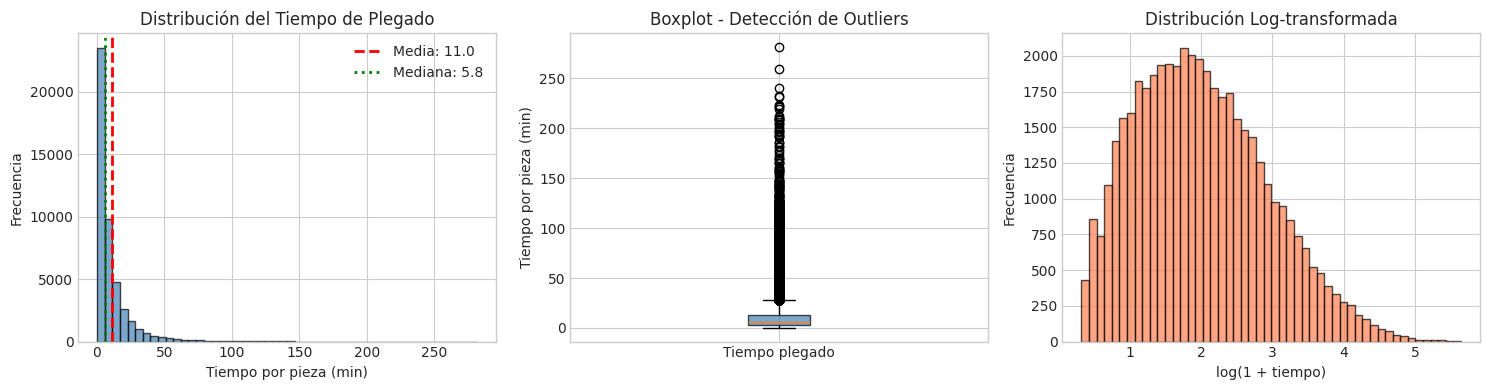

plegado_v3_target_distribution.png


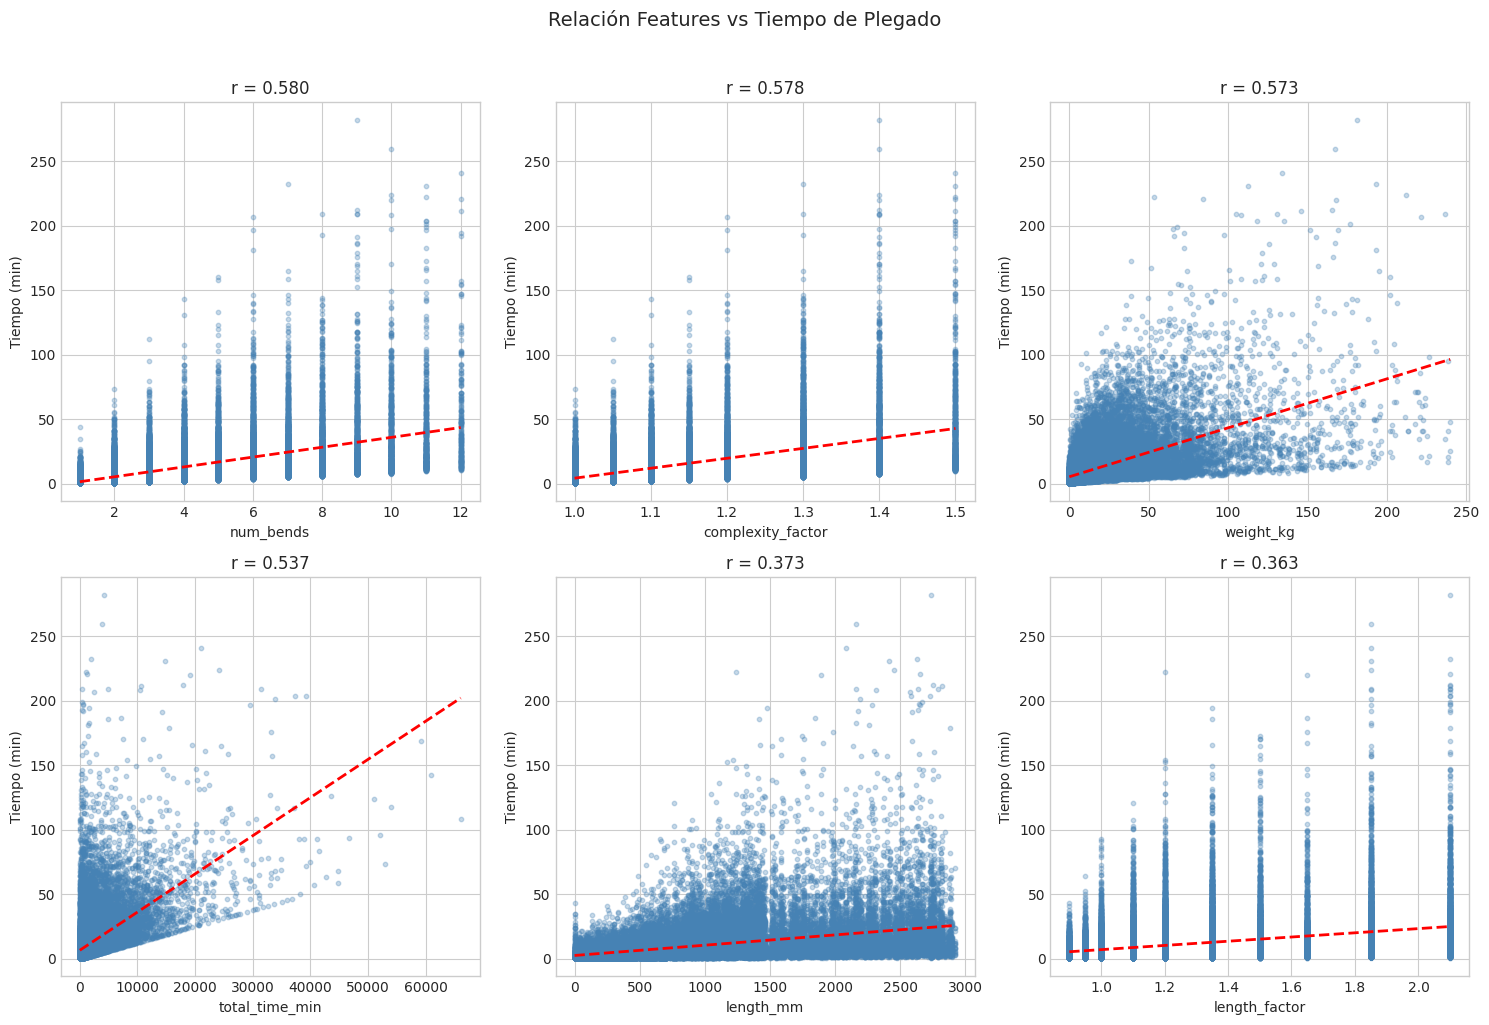

plegado_v3_scatter_features.png


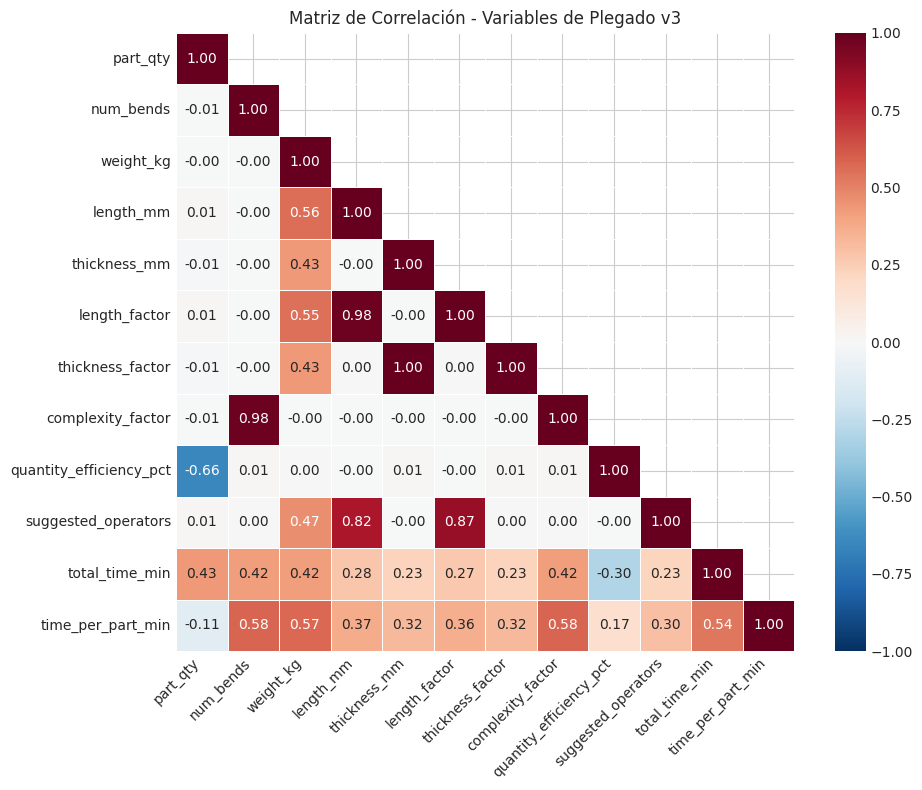

plegado_v3_correlation_matrix.png


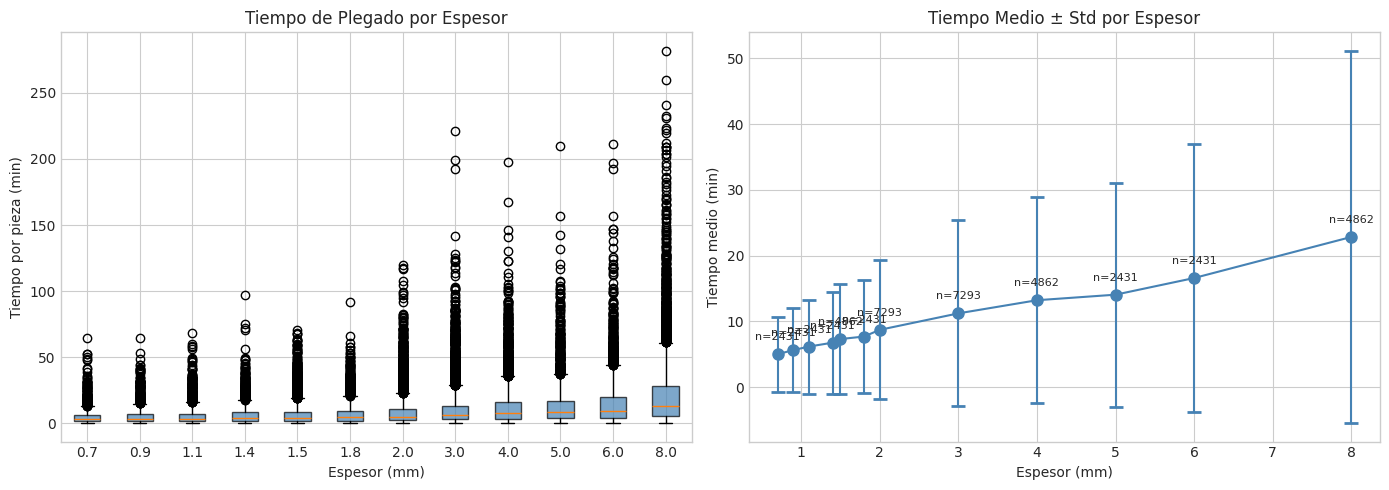

plegado_v3_analisis_espesor.png


In [14]:
# =============================================================================
# Análisis Exploratorio - Plegado v3
# TFM: Predicción de Tiempos de Producción
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================
print("=" * 70)
print("ANÁLISIS EXPLORATORIO - PLEGADO v3")
print("=" * 70)

# Columnas v3
cols_v3 = [col for col in df_sintetico.columns if 'v3' in col.lower() and  'cost' not in col.lower() ]
df_v3 = df_sintetico[cols_v3].copy()

print(f"\nRegistros: {len(df_v3):,}")
print(f"Columnas v3: {len(cols_v3)}")

# =============================================================================
# 2. IDENTIFICAR VARIABLES CONSTANTES vs VARIABLES
# =============================================================================
print("\n" + "=" * 70)
print("2. CLASIFICACIÓN DE VARIABLES")
print("=" * 70)

cols_numericas = df_v3.select_dtypes(include=[np.number]).columns.tolist()

constantes = []
variables = []

for col in cols_numericas:
    if df_v3[col].nunique() <= 1:
        constantes.append(col)
    else:
        variables.append(col)

print(f"\nVARIABLES CONSTANTES (sin valor predictivo): {len(constantes)}")
for col in constantes:
    print(f"   - {col} = {df_v3[col].iloc[0]}")

print(f"\nVARIABLES CON VARIABILIDAD: {len(variables)}")
for col in variables:
    cv = (df_v3[col].std() / df_v3[col].mean() * 100) if df_v3[col].mean() != 0 else 0
    print(f"   - {col}: rango [{df_v3[col].min():.2f}, {df_v3[col].max():.2f}], CV={cv:.1f}%")

# =============================================================================
# 3. ANÁLISIS DE LA VARIABLE TARGET
# =============================================================================
print("\n" + "=" * 70)
print("3. ANÁLISIS DE VARIABLE TARGET: bend_v3_time_per_part_min")
print("=" * 70)

target = 'bend_v3_time_per_part_min'
y = df_v3[target]

print(f"""
Estadísticas del tiempo de plegado por pieza:
  - Media:     {y.mean():.2f} min
  - Mediana:   {y.median():.2f} min
  - Std:       {y.std():.2f} min
  - Min:       {y.min():.2f} min
  - Max:       {y.max():.2f} min
  - Skewness:  {y.skew():.2f} (cola derecha)
  - Kurtosis:  {y.kurtosis():.2f}
""")

# Percentiles
print("Percentiles:")
for p in [10, 25, 50, 75, 90, 95, 99]:
    print(f"  P{p}: {y.quantile(p/100):.2f} min")

# =============================================================================
# 4. CORRELACIONES CON EL TARGET
# =============================================================================
print("\n" + "=" * 70)
print("4. CORRELACIONES CON EL TIEMPO DE PLEGADO")
print("=" * 70)

# Solo variables numéricas con variabilidad
features_validas = [col for col in variables if col != target]

correlaciones = {}
for col in features_validas:
    corr = df_v3[col].corr(y)
    correlaciones[col] = corr

corr_df = pd.DataFrame({
    'Feature': list(correlaciones.keys()),
    'Correlación': list(correlaciones.values())
}).sort_values('Correlación', key=abs, ascending=False)

print("\nCorrelaciones con bend_v3_time_per_part_min:")
print("-" * 50)
for _, row in corr_df.iterrows():
    bar = '|' * int(abs(row['Correlación']) * 20)
    sign = '+' if row['Correlación'] > 0 else '-'
    print(f"  {row['Feature'].replace('bend_v3_', ''):<25} {sign}{abs(row['Correlación']):.3f} {bar}")

# =============================================================================
# 5. VISUALIZACIONES
# =============================================================================
print("\n" + "=" * 70)
print("5. GENERANDO VISUALIZACIONES...")
print("=" * 70)

# 5.1 Distribución del target
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histograma
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {y.mean():.1f}')
axes[0].axvline(y.median(), color='green', linestyle=':', linewidth=2, label=f'Mediana: {y.median():.1f}')
axes[0].set_xlabel('Tiempo por pieza (min)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución del Tiempo de Plegado')
axes[0].legend()

# Boxplot
axes[1].boxplot(y, vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.7))
axes[1].set_ylabel('Tiempo por pieza (min)')
axes[1].set_title('Boxplot - Detección de Outliers')
axes[1].set_xticklabels(['Tiempo plegado'])

# Log-transform
axes[2].hist(np.log1p(y), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[2].set_xlabel('log(1 + tiempo)')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución Log-transformada')

plt.tight_layout()
plt.savefig('plegado_v3_target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("plegado_v3_target_distribution.png")

# 5.2 Scatter plots: Features vs Target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

top_features = corr_df.head(6)['Feature'].tolist()

for i, feat in enumerate(top_features):
    ax = axes[i]
    ax.scatter(df_v3[feat], y, alpha=0.3, s=10, c='steelblue')
    
    # Línea de tendencia
    z = np.polyfit(df_v3[feat], y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_v3[feat].min(), df_v3[feat].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2)
    
    corr_val = correlaciones[feat]
    ax.set_xlabel(feat.replace('bend_v3_', ''))
    ax.set_ylabel('Tiempo (min)')
    ax.set_title(f'r = {corr_val:.3f}')

plt.suptitle('Relación Features vs Tiempo de Plegado', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plegado_v3_scatter_features.png', dpi=150, bbox_inches='tight')
plt.show()
print("plegado_v3_scatter_features.png")

# 5.3 Matriz de correlación (solo variables útiles)
features_modelo = features_validas + [target]
corr_matrix = df_v3[features_modelo].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax,
            square=True, linewidths=0.5,
            vmin=-1, vmax=1)
ax.set_title('Matriz de Correlación - Variables de Plegado v3', fontsize=12)

# Simplificar etiquetas
labels = [col.replace('bend_v3_', '') for col in features_modelo]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig('plegado_v3_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("plegado_v3_correlation_matrix.png")

# 5.4 Análisis por espesor
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot por espesor
espesores = sorted(df_v3['bend_v3_thickness_mm'].unique())
data_by_thickness = [df_v3[df_v3['bend_v3_thickness_mm'] == e][target].values for e in espesores]

bp = axes[0].boxplot(data_by_thickness, labels=[f'{e:.1f}' for e in espesores], 
                      patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
axes[0].set_xlabel('Espesor (mm)')
axes[0].set_ylabel('Tiempo por pieza (min)')
axes[0].set_title('Tiempo de Plegado por Espesor')

# Media por espesor
medias = df_v3.groupby('bend_v3_thickness_mm')[target].agg(['mean', 'std', 'count'])
axes[1].errorbar(medias.index, medias['mean'], yerr=medias['std'], 
                 fmt='o-', capsize=5, capthick=2, markersize=8, color='steelblue')
axes[1].set_xlabel('Espesor (mm)')
axes[1].set_ylabel('Tiempo medio (min)')
axes[1].set_title('Tiempo Medio ± Std por Espesor')

# Añadir etiquetas de n
for x, row in medias.iterrows():
    axes[1].annotate(f'n={int(row["count"])}', (x, row['mean']), 
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('plegado_v3_analisis_espesor.png', dpi=150, bbox_inches='tight')
plt.show()
print("plegado_v3_analisis_espesor.png")



In [15]:
# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================
print("=" * 70)
print("ANÁLISIS EXPLORATORIO - PLEGADO v3")
print("=" * 70)

# Columnas v3
cols_v3 = [col for col in df_real.columns ]
df_v3 = df_real[cols_v3].copy()

print(f"\nRegistros: {len(df_v3):,}")
print(f"Columnas v3: {len(cols_v3)}")

# =============================================================================
# 2. IDENTIFICAR VARIABLES CONSTANTES vs VARIABLES
# =============================================================================
print("\n" + "=" * 70)
print("2. CLASIFICACIÓN DE VARIABLES")
print("=" * 70)

cols_numericas = df_v3.select_dtypes(include=[np.number]).columns.tolist()

constantes = []
variables = []

for col in cols_numericas:
    if df_v3[col].nunique() <= 1:
        constantes.append(col)
    else:
        variables.append(col)

print(f"\nVARIABLES CONSTANTES (sin valor predictivo): {len(constantes)}")
for col in constantes:
    print(f"   - {col} = {df_v3[col].iloc[0]}")

print(f"\nVARIABLES CON VARIABILIDAD: {len(variables)}")
for col in variables:
    cv = (df_v3[col].std() / df_v3[col].mean() * 100) if df_v3[col].mean() != 0 else 0
    print(f"   - {col}: rango [{df_v3[col].min():.2f}, {df_v3[col].max():.2f}], CV={cv:.1f}%")


ANÁLISIS EXPLORATORIO - PLEGADO v3

Registros: 64
Columnas v3: 25

2. CLASIFICACIÓN DE VARIABLES

VARIABLES CONSTANTES (sin valor predictivo): 0

VARIABLES CON VARIABILIDAD: 17
   - Tiempo de mecanizado nominal [min]: rango [0.50, 396.00], CV=187.4%
   - Tiempo de mecanizado real [min]: rango [0.04, 203.42], CV=115.4%
   - Cantidad real: rango [1.00, 792.00], CV=185.9%
   - Peso por unidad: rango [0.01, 91.35], CV=367.2%
   - Anchura: rango [19.09, 1462.25], CV=126.6%
   - Longitud: rango [25.00, 2311.05], CV=87.3%
   - Espesor_mm: rango [0.07, 1.50], CV=89.4%
   - Tiempo_unitario_real_min: rango [0.00, 12.71], CV=148.0%
   - bounding_box_area: rango [850.00, 3378224.78], CV=245.6%
   - aspect_ratio: rango [1.02, 45.23], CV=151.5%
   - perimetro_aproximado: rango [118.00, 7545.08], CV=89.4%
   - Tiempo_unitario_nominal_min: rango [0.28, 0.78], CV=10.5%
   - bounding_box_area_mm2: rango [850.00, 3378224.78], CV=245.6%
   - perimetro_aproximado_mm: rango [118.00, 7545.08], CV=89.4%
   - 

## 4. Funciones de Preprocesamiento

Funciones auxiliares para conversion de tiempos y eliminacion de outliers.

In [16]:
# =============================================================================
# 4. FUNCIONES DE PREPROCESAMIENTO
# =============================================================================

def convertir_tiempo_a_minutos(val):
    """
    Convierte tiempo de formato HH:MM:SS a minutos.
    
    Maneja:
    - Valores numericos (ya en minutos)
    - Strings formato HH:MM:SS
    - Strings formato MM:SS
    - NaN y valores invalidos
    """
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    if isinstance(val, str):
        try:
            parts = val.split(':')
            if len(parts) == 3:
                h, m, s = map(float, parts)
                return h * 60 + m + s / 60
            elif len(parts) == 2:
                m, s = map(float, parts)
                return m + s / 60
        except:
            pass
    try:
        return float(val)
    except:
        return np.nan


def eliminar_outliers_iqr(df, columna, factor=1.5):
    """
    Elimina outliers usando el metodo IQR.
    
    Args:
        df: DataFrame
        columna: nombre de la columna a analizar
        factor: multiplicador del IQR (default 1.5)
    
    Returns:
        df_clean: DataFrame sin outliers
        n_outliers: numero de outliers eliminados
    """
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - factor * IQR
    limite_superior = Q3 + factor * IQR
    
    mask = (df[columna] >= limite_inferior) & (df[columna] <= limite_superior)
    
    n_outliers = (~mask).sum()
    df_clean = df[mask].copy()
    
    return df_clean, n_outliers


def eliminar_outliers_por_grupo(df, col_grupo, col_valor, factor=1.5):
    """
    Elimina outliers por cada grupo (ej: material) de forma independiente.
    
    Aplica IQR dentro de cada grupo para respetar las diferencias
    naturales entre materiales/espesores.
    
    Args:
        df: DataFrame
        col_grupo: columna para agrupar (ej: 'MaterialTruTops')
        col_valor: columna con valores a filtrar (ej: 'tiempo')
        factor: multiplicador del IQR
    
    Returns:
        df_clean: DataFrame sin outliers
        total_outliers: total de outliers eliminados
    """
    df_clean_list = []
    total_outliers = 0
    
    for grupo in df[col_grupo].unique():
        df_grupo = df[df[col_grupo] == grupo]
        
        if len(df_grupo) >= 4:  # Minimo para calcular IQR
            df_grupo_clean, n_out = eliminar_outliers_iqr(df_grupo, col_valor, factor)
            total_outliers += n_out
        else:
            df_grupo_clean = df_grupo
        
        df_clean_list.append(df_grupo_clean)
    
    df_clean = pd.concat(df_clean_list, ignore_index=True)
    return df_clean, total_outliers


print("Funciones definidas:")
print("  - convertir_tiempo_a_minutos()")
print("  - eliminar_outliers_iqr()")
print("  - eliminar_outliers_por_grupo()")

Funciones definidas:
  - convertir_tiempo_a_minutos()
  - eliminar_outliers_iqr()
  - eliminar_outliers_por_grupo()


## 5. Limpieza de Datos REALES

In [17]:
# =============================================================================
# 5. LIMPIEZA DATOS REALES (complementaria)
# =============================================================================

print("=" * 60)
print("LIMPIEZA DATOS REALES")
print("=" * 60)

n_inicial = len(df_real)
print(f"\nRegistros cargados: {n_inicial}")

# Los datos ya vienen limpios de Notebook 1
# Aquí solo aplicamos outliers por material

n_antes = len(df_real)
df_real_clean, n_outliers = eliminar_outliers_por_grupo(
    df_real, COL_MATERIAL_REAL, COL_TIEMPO_REAL, IQR_FACTOR
)

print(f"\nOutliers eliminados (IQR por material): {n_outliers}")
print(f"\n{'-'*40}")
print(f"REGISTROS REALES FINALES: {len(df_real_clean)} ({len(df_real_clean)/n_inicial*100:.1f}%)")
print(f"{'-'*40}")

LIMPIEZA DATOS REALES

Registros cargados: 64

Outliers eliminados (IQR por material): 4

----------------------------------------
REGISTROS REALES FINALES: 60 (93.8%)
----------------------------------------


## 6. Preprocesamiento de Datos Sinteticos

Los datos de TruTops Calculate requieren transformaciones especificas:

1. Eliminacion de outliers por material

In [18]:
# =============================================================================
# 6. PREPROCESAMIENTO DATOS SINTETICOS
# =============================================================================

print("=" * 60)
print("PREPROCESAMIENTO DATOS SINTETICOS")
print("=" * 60)

n_inicial_sint = len(df_sintetico)
print(f"\nRegistros iniciales: {n_inicial_sint:,}")

# --- Paso 1: Convertir tiempo a minutos ---
if df_sintetico[COL_TIEMPO_SINT].dtype == 'object':
    df_sintetico['tiempo_min'] = df_sintetico[COL_TIEMPO_SINT].apply(convertir_tiempo_a_minutos)
    COL_TIEMPO_SINT_NUM = 'tiempo_min'
    print(f"\n1. Tiempo convertido de HH:MM:SS a minutos")
else:
    COL_TIEMPO_SINT_NUM = COL_TIEMPO_SINT
    print(f"\n1. Tiempo ya en formato numerico")

# # --- Paso 1b: Corregir tiempos = 0 ---
# mask_tiempo_cero = df_sintetico[COL_TIEMPO_SINT_NUM] == 0
# if mask_tiempo_cero.any():
#     # Convertir componentes de tiempo
#     if df_sintetico['laser_time'].dtype == 'object':
#         laser_min = df_sintetico['laser_time'].apply(convertir_tiempo_a_minutos)
#     else:
#         laser_min = df_sintetico['laser_time']
    
#     if df_sintetico['positioning_time'].dtype == 'object':
#         pos_min = df_sintetico['positioning_time'].apply(convertir_tiempo_a_minutos)
#     else:
#         pos_min = df_sintetico['positioning_time']
    
#     # Reemplazar ceros con suma de componentes
#     df_sintetico.loc[mask_tiempo_cero, COL_TIEMPO_SINT_NUM] = (laser_min + pos_min)[mask_tiempo_cero]
#     print(f"   Corregidos {mask_tiempo_cero.sum()} registros con tiempo=0")

df_sint_clean = df_sintetico.copy()

# --- Paso 2: Restar tiempo de cambio de preparacion plegado
print(f"\n2. Restando {TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL} min de setup plegado... entre cantidad piezas plegado piezas")
print(f"   Media antes: {df_sint_clean[COL_TIEMPO_SINT_NUM].mean():.3f} min")

tiempo_setup_por_pieza = TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL / df_sint_clean['bend_v3_part_qty']
df_sint_clean['tiempo_sin_setup'] = np.where(
    df_sint_clean[COL_TIEMPO_SINT_NUM] > tiempo_setup_por_pieza,
    df_sint_clean[COL_TIEMPO_SINT_NUM] - tiempo_setup_por_pieza,
    df_sint_clean[COL_TIEMPO_SINT_NUM]
)
print(f"   Media despues: {df_sint_clean['tiempo_sin_setup'].mean():.3f} min")

# --- Paso 3: Eliminar tiempos o dimensiones <= 0 ---
n_antes = len(df_sint_clean)
df_sint_clean = df_sint_clean[
    (df_sint_clean['tiempo_sin_setup'] > 0) & 
    (df_sint_clean['part_dimensions_x_mm'] > 0) & 
    (df_sint_clean['part_dimensions_y_mm'] > 0)
]
n_negativos = n_antes - len(df_sint_clean)
print(f"\n3. Eliminados por tiempo/dimension <= 0: {n_negativos}")

# Actualizar nombre de columna
COL_TIEMPO_SINT_FINAL = 'tiempo_sin_setup'

# --- Paso 4: Eliminar outliers por material ---
n_antes = len(df_sint_clean)
df_sint_clean, n_outliers = eliminar_outliers_por_grupo(
    df_sint_clean, COL_MATERIAL_SINT, COL_TIEMPO_SINT_FINAL, IQR_FACTOR
)
print(f"\n4. Outliers eliminados (IQR por material): {n_outliers}")

# --- Resumen ---
print(f"\n{'='*60}")
print(f"REGISTROS SINTETICOS FINALES: {len(df_sint_clean):,} ({len(df_sint_clean)/n_inicial_sint*100:.1f}%)")
print(f"{'='*60}")

PREPROCESAMIENTO DATOS SINTETICOS

Registros iniciales: 46,189

1. Tiempo ya en formato numerico

2. Restando 0 min de setup plegado... entre cantidad piezas plegado piezas
   Media antes: 10.965 min
   Media despues: 10.965 min

3. Eliminados por tiempo/dimension <= 0: 323

4. Outliers eliminados (IQR por material): 3577

REGISTROS SINTETICOS FINALES: 42,289 (91.6%)


=== ANÁLISIS VISUAL DATOS SINTÉTICOS ===

Registros sintéticos (tras preprocesamiento): 42,289


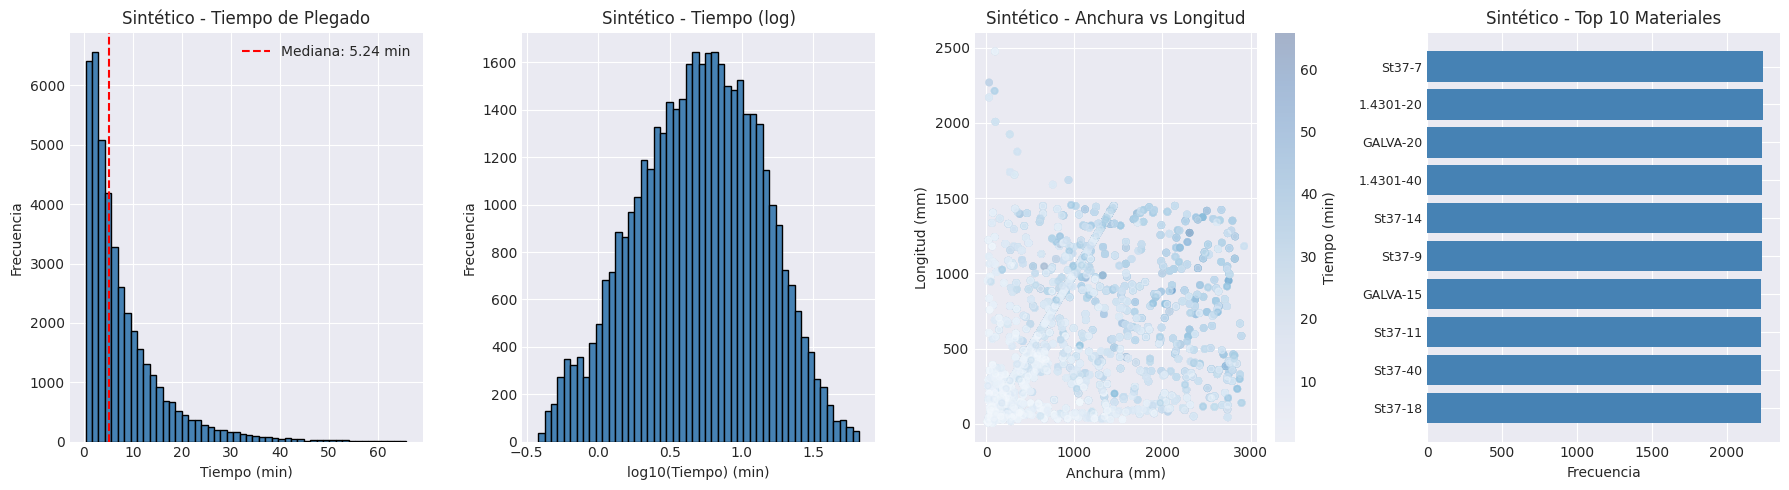


Gráfico guardado: analisis_datos_sinteticos.png

COMPARATIVA ESTADÍSTICA: REALES vs SINTÉTICOS

Métrica                        Reales          Sintéticos     
------------------------------------------------------------
Registros                      64              42,289         
Mediana tiempo (min)           0.93            5.24           
Media tiempo (min)             1.54            7.95           
Std tiempo (min)               2.27            8.17           
Max anchura (mm)               1462            2925           
Max longitud (mm)              2311            2475           
Materiales distintos           16              19             


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# ANÁLISIS VISUAL DATOS SINTÉTICOS (similar al de datos reales)
# =============================================================================

print("=== ANÁLISIS VISUAL DATOS SINTÉTICOS ===\n")
print(f"Registros sintéticos (tras preprocesamiento): {len(df_sint_clean):,}")

# CONFIGURACIÓN
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 5))

# Definir columnas sintéticas
COL_TIEMPO = 'tiempo_sin_setup'
COL_ANCHURA = 'part_dimensions_x_mm'
COL_LONGITUD = 'part_dimensions_y_mm'
COL_MATERIAL = 'material_name'  

# ========== CORTE LÁSER SINTÉTICO ==========

# 1. Distribución Tiempo (lineal)
plt.subplot(1, 4, 1)
plt.hist(df_sint_clean[COL_TIEMPO], bins=50, edgecolor='black', color='steelblue')
plt.xlabel('Tiempo (min)')
plt.ylabel('Frecuencia')
plt.title('Sintético - Tiempo de Plegado')
mediana = df_sint_clean[COL_TIEMPO].median()
plt.axvline(mediana, color='red', linestyle='--', 
            label=f"Mediana: {mediana:.2f} min")
plt.legend()

# 2. Distribución Tiempo (log)
plt.subplot(1, 4, 2)
# Filtrar valores positivos para log
tiempos_positivos = df_sint_clean[df_sint_clean[COL_TIEMPO] > 0][COL_TIEMPO]
plt.hist(np.log10(tiempos_positivos), bins=50, edgecolor='black', color='steelblue')
plt.xlabel('log10(Tiempo) (min)')
plt.ylabel('Frecuencia')
plt.title('Sintético - Tiempo (log)')

# 3. Anchura vs Longitud
plt.subplot(1, 4, 3)
scatter = plt.scatter(df_sint_clean[COL_ANCHURA], df_sint_clean[COL_LONGITUD], 
                     c=df_sint_clean[COL_TIEMPO], 
                     cmap='Blues', alpha=0.3, s=20)  # alpha bajo por muchos puntos
plt.xlabel('Anchura (mm)')
plt.ylabel('Longitud (mm)')
plt.title('Sintético - Anchura vs Longitud')
plt.colorbar(scatter, label='Tiempo (min)')

# 4. Top materiales
plt.subplot(1, 4, 4)
material_counts = df_sint_clean[COL_MATERIAL].value_counts().head(10)
plt.barh(range(len(material_counts)), material_counts.values, color='steelblue')
plt.yticks(range(len(material_counts)), material_counts.index, fontsize=9)
plt.xlabel('Frecuencia')
plt.title('Sintético - Top 10 Materiales')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('analisis_datos_sinteticos.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado: analisis_datos_sinteticos.png")

# Estadísticas comparativas
print("\n" + "="*60)
print("COMPARATIVA ESTADÍSTICA: REALES vs SINTÉTICOS")
print("="*60)
print(f"\n{'Métrica':<30} {'Reales':<15} {'Sintéticos':<15}")
print("-"*60)
print(f"{'Registros':<30} {len(df_real):<15,} {len(df_sint_clean):<15,}")
print(f"{'Mediana tiempo (min)':<30} {df_real[COL_TIEMPO_REAL].median():<15.2f} {df_sint_clean[COL_TIEMPO].median():<15.2f}")
print(f"{'Media tiempo (min)':<30} {df_real[COL_TIEMPO_REAL].mean():<15.2f} {df_sint_clean[COL_TIEMPO].mean():<15.2f}")
print(f"{'Std tiempo (min)':<30} {df_real[COL_TIEMPO_REAL].std():<15.2f} {df_sint_clean[COL_TIEMPO].std():<15.2f}")
print(f"{'Max anchura (mm)':<30} {df_real['Anchura'].max():<15.0f} {df_sint_clean[COL_ANCHURA].max():<15.0f}")
print(f"{'Max longitud (mm)':<30} {df_real['Longitud'].max():<15.0f} {df_sint_clean[COL_LONGITUD].max():<15.0f}")
print(f"{'Materiales distintos':<30} {df_real[COL_MATERIAL_REAL].nunique():<15} {df_sint_clean[COL_MATERIAL].nunique():<15}")

## Resumen del preprocesamiento sintetico

| Etapa | Registros | Observacion |
|-------|-----------|-------------|
| Inicial | 46,189 | -- |
| Resta setup (0 min) | 46,189 | Media: 10.97 min (sin cambio) |
| Eliminar tiempo/dim <= 0 | 45,866 | -323 |
| Outliers IQR por material | 42,289 | -3,577 |
| **Final** | **42,289** | **91.6% retenido** |

## Resumen de limpieza de datos

### Datos reales
- **Registros iniciales**: 64
- **Registros finales**: 60 (93.8% retenido)

Filtros aplicados:
1. Nominal == Real: 0 eliminados (registros sin medición real válida)
2. Outliers IQR por material: 4 eliminados

### Datos sintéticos
- **Registros iniciales**: 46,189
- **Registros finales**: 42,289  (91.6% retenido)

Filtros aplicados:

1. Resta de tiempo fijo de setup de bandeja (0 min): media pasa de 4.539 a 1.539 min
2. Tiempo o tamaño <= 0 post-setup: 323 eliminados (piezas con tiempo total menor al setup fijo)
3. Outliers IQR por material: 1,773 eliminados



## 7. Feature Engineering y Seleccion de Variables

### 7.1 Creacion de features en datos sinteticos

Se crean las mismas variables derivadas que en los datos reales para garantizar compatibilidad.

In [256]:
# =============================================================================
# 7. FEATURE ENGINEERING SINTETICOS
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING SINTETICOS")
print("=" * 60)

# Calcular aspect_ratio si no existe
if 'aspect_ratio' not in df_sint_clean.columns:
    df_sint_clean['aspect_ratio'] = (
        df_sint_clean['part_dimensions_y_mm'] / df_sint_clean['part_dimensions_x_mm']
    )
    # Normalizar para que siempre sea >= 1
    mask = df_sint_clean['aspect_ratio'] < 1
    df_sint_clean.loc[mask, 'aspect_ratio'] = 1 / df_sint_clean.loc[mask, 'aspect_ratio']
    print("Creado: aspect_ratio (normalizado >= 1)")

# Calcular perimetro si no existe
if 'perimetro' not in df_sint_clean.columns:
    df_sint_clean['perimetro'] = 2 * (
        df_sint_clean['part_dimensions_x_mm'] + df_sint_clean['part_dimensions_y_mm']
    )
    print("Creado: perimetro")

# Verificar features disponibles
print("\nFeatures REALES disponibles:")
features_real_ok = [f for f in FEATURES_REAL if f in df_real_clean.columns]
features_real_miss = [f for f in FEATURES_REAL if f not in df_real_clean.columns]
print(f"  Disponibles: {features_real_ok}")
if features_real_miss:
    print(f"  Faltan: {features_real_miss}")

print("\nFeatures SINTETICOS disponibles:")
features_sint_ok = [FEATURE_MAPPING[f] for f in features_real_ok if FEATURE_MAPPING[f] in df_sint_clean.columns]
print(f"  Disponibles: {features_sint_ok}")

# Actualizar listas de features a usar
FEATURES_USAR_REAL = [f for f in features_real_ok if FEATURE_MAPPING[f] in df_sint_clean.columns]
FEATURES_USAR_SINT = [FEATURE_MAPPING[f] for f in FEATURES_USAR_REAL]

print(f"\nFeatures candidatas: {FEATURES_USAR_REAL}")

FEATURE ENGINEERING SINTETICOS
Creado: aspect_ratio (normalizado >= 1)
Creado: perimetro

Features REALES disponibles:
  Disponibles: ['Anchura', 'Longitud', 'bounding_box_area_mm2', 'aspect_ratio', 'perimetro_aproximado_mm', 'Cantidad real', 'Peso por unidad']

Features SINTETICOS disponibles:
  Disponibles: ['part_dimensions_x_mm', 'part_dimensions_y_mm', 'part_area_mm2', 'aspect_ratio', 'perimetro', 'bend_v3_part_qty', 'part_weight_kg']

Features candidatas: ['Anchura', 'Longitud', 'bounding_box_area_mm2', 'aspect_ratio', 'perimetro_aproximado_mm', 'Cantidad real', 'Peso por unidad']


HEATMAPS DE CORRELACIONES
Datos reales: 56 registros
Datos sinteticos: 28,910 registros


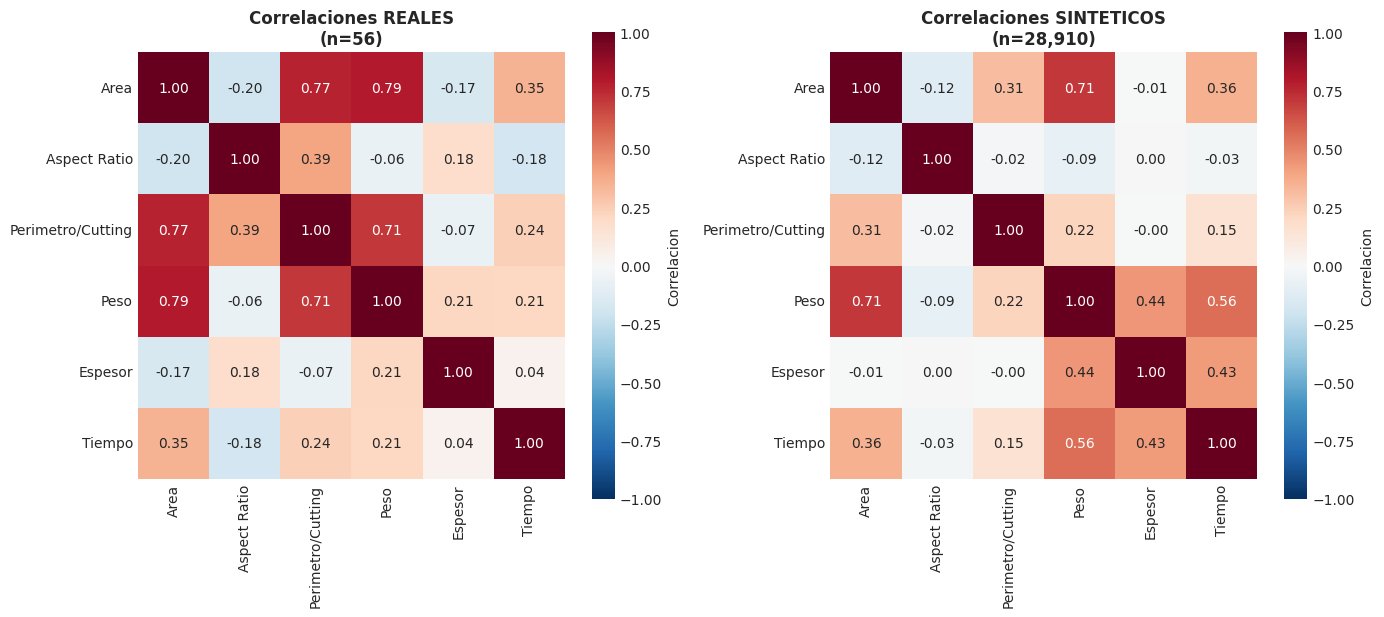


Guardado: heatmap_correlaciones_real_vs_sint.png

------------------------------------------------------------
DIFERENCIAS DE CORRELACION (Real - Sintetico)
------------------------------------------------------------


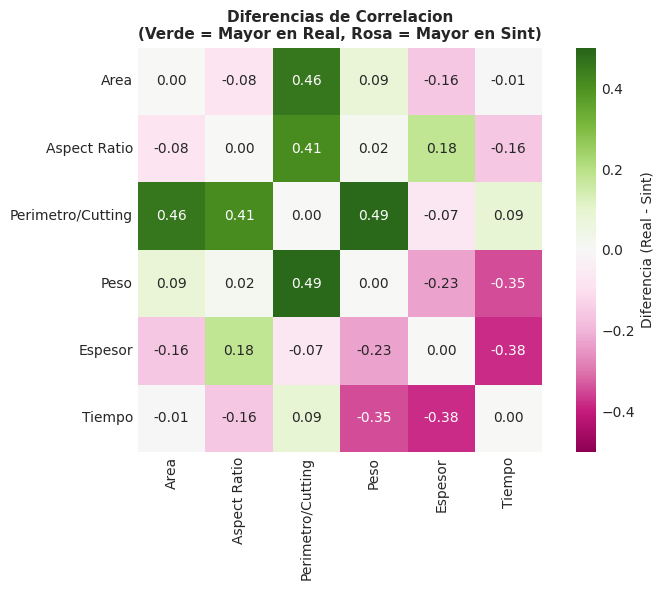


Guardado: heatmap_diferencias_correlacion.png

------------------------------------------------------------
CORRELACIONES CON TIEMPO
------------------------------------------------------------

Feature                    Real  Sintetico   Diferencia
------------------------------------------------------
Area                      0.348      0.355       -0.007
Aspect Ratio             -0.184     -0.025       -0.159
Perimetro/Cutting         0.237      0.150       +0.087
Peso                      0.209      0.555       -0.346
Espesor                   0.044      0.426       -0.382
------------------------------------------------------

Discrepancias significativas (|diff| > 0.15):
   - Aspect Ratio: Real=-0.184, Sint=-0.025, Diff=-0.159
   - Peso: Real=0.209, Sint=0.555, Diff=-0.346
   - Espesor: Real=0.044, Sint=0.426, Diff=-0.382


In [291]:
# =============================================================================
# HEATMAPS DE CORRELACIONES - REALES vs SINTETICOS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 60)
print("HEATMAPS DE CORRELACIONES")
print("=" * 60)

# Features a comparar (incluir target)
FEATURES_CORR_REAL = ['bounding_box_area_mm2', 'aspect_ratio', 'perimetro_aproximado', 
                       'peso_kg', 'espesor_mm', COL_TIEMPO_REAL]

FEATURES_CORR_SINT = ['part_area_mm2', 'aspect_ratio', 'cutting_length_mm',
                       'part_weight_kg', 'espesor_mm', COL_TIEMPO_SINT_FINAL]

# Etiquetas comunes para ambos heatmaps
LABELS_COMUNES = ['Area', 'Aspect Ratio', 'Perimetro/Cutting', 
                   'Peso', 'Espesor', 'Tiempo']

# Calcular correlaciones
df_corr_real = df_real_clean[FEATURES_CORR_REAL].dropna()
df_corr_sint = df_sint_clean[FEATURES_CORR_SINT].dropna()

corr_real = df_corr_real.corr()
corr_sint = df_corr_sint.corr()

# Renombrar para visualizacion
corr_real.index = LABELS_COMUNES
corr_real.columns = LABELS_COMUNES
corr_sint.index = LABELS_COMUNES
corr_sint.columns = LABELS_COMUNES

print(f"Datos reales: {len(df_corr_real)} registros")
print(f"Datos sinteticos: {len(df_corr_sint):,} registros")

# Crear figura con dos heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap REALES
sns.heatmap(corr_real, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0],
            cbar_kws={'label': 'Correlacion'})
axes[0].set_title(f'Correlaciones REALES\n(n={len(df_corr_real)})', fontsize=12, fontweight='bold')

# Heatmap SINTETICOS
sns.heatmap(corr_sint, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1],
            cbar_kws={'label': 'Correlacion'})
axes[1].set_title(f'Correlaciones SINTETICOS\n(n={len(df_corr_sint):,})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('heatmap_correlaciones_real_vs_sint.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGuardado: heatmap_correlaciones_real_vs_sint.png")

# -----------------------------------------------------------------------------
# DIFERENCIAS DE CORRELACION
# -----------------------------------------------------------------------------

print(f"\n{'-'*60}")
print("DIFERENCIAS DE CORRELACION (Real - Sintetico)")
print(f"{'-'*60}")

diff_corr = corr_real - corr_sint

# Heatmap de diferencias
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(diff_corr, annot=True, fmt='.2f', cmap='PiYG', center=0,
            vmin=-0.5, vmax=0.5, square=True, ax=ax,
            cbar_kws={'label': 'Diferencia (Real - Sint)'})
ax.set_title('Diferencias de Correlacion\n(Verde = Mayor en Real, Rosa = Mayor en Sint)', 
             fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('heatmap_diferencias_correlacion.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGuardado: heatmap_diferencias_correlacion.png")

# -----------------------------------------------------------------------------
# TABLA RESUMEN: CORRELACIONES CON TIEMPO
# -----------------------------------------------------------------------------

print(f"\n{'-'*60}")
print("CORRELACIONES CON TIEMPO")
print(f"{'-'*60}")

print(f"\n{'Feature':<20} {'Real':>10} {'Sintetico':>10} {'Diferencia':>12}")
print(f"{'-'*54}")

for i, label in enumerate(LABELS_COMUNES[:-1]):  # Excluir Tiempo vs Tiempo
    corr_r = corr_real.loc[label, 'Tiempo']
    corr_s = corr_sint.loc[label, 'Tiempo']
    diff = corr_r - corr_s
    print(f"{label:<20} {corr_r:>10.3f} {corr_s:>10.3f} {diff:>+12.3f}")

print(f"{'-'*54}")

# Identificar discrepancias significativas
print(f"\nDiscrepancias significativas (|diff| > 0.15):")
for i, label in enumerate(LABELS_COMUNES[:-1]):
    corr_r = corr_real.loc[label, 'Tiempo']
    corr_s = corr_sint.loc[label, 'Tiempo']
    diff = corr_r - corr_s
    if abs(diff) > 0.15:
        print(f"   - {label}: Real={corr_r:.3f}, Sint={corr_s:.3f}, Diff={diff:+.3f}")

### 7.2 Analisis de Multicolinealidad (VIF)

El Variance Inflation Factor (VIF) detecta variables altamente correlacionadas que 
pueden causar inestabilidad en los coeficientes del modelo.

| VIF | Interpretacion |
|-----|----------------|
| 1 | Sin correlacion |
| < 5 | Aceptable |
| 5-10 | Preocupante |
| > 10 | Eliminar variable |

In [289]:
# =============================================================================
# ANALISIS DE MULTICOLINEALIDAD - VIF  DATOS REALES
# =============================================================================

from statsmodels.stats.outliers_influence import variance_inflation_factor

print("=" * 60)
print("ANALISIS DE MULTICOLINEALIDAD - VIF")
print("=" * 60)

UMBRAL_VIF = 7

# Preparar datos para VIF (usar datos reales, sin NaN)
df_vif = df_real_clean[FEATURES_USAR_REAL].dropna()

if len(df_vif) > len(FEATURES_USAR_REAL):
    
    features_finales = FEATURES_USAR_REAL.copy()
    iteracion = 0
    
    # Eliminacion iterativa de variables con VIF alto
    while True:
        iteracion += 1
        
        X_vif = df_vif[features_finales].values
        
        vif_data = pd.DataFrame()
        vif_data["Feature"] = features_finales
        vif_data["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(len(features_finales))]
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        max_vif = vif_data['VIF'].max()
        
        if max_vif <= UMBRAL_VIF or len(features_finales) <= 2:
            break
        
        # Eliminar feature con mayor VIF
        feature_eliminar = vif_data.iloc[0]['Feature']
        print(f"Iteracion {iteracion}: Eliminando '{feature_eliminar}' (VIF = {max_vif:.2f})")
        features_finales.remove(feature_eliminar)
    
    # Mostrar VIF final
    print(f"\n{'-'*50}")
    print("VIF FINAL:")
    print(f"{'-'*50}")
    print(vif_data.to_string(index=False))
    
    # Actualizar listas de features
    FEATURES_USAR_REAL = features_finales
    FEATURES_USAR_SINT = [FEATURE_MAPPING[f] for f in FEATURES_USAR_REAL]
    
    eliminadas = set(features_real_ok) - set(FEATURES_USAR_REAL)
    if eliminadas:
        print(f"\nFeatures eliminadas por VIF: {eliminadas}")
else:
    print("Insuficientes datos para calcular VIF, manteniendo todas las features")

print(f"\n{'='*60}")
print(f"FEATURES FINALES: {FEATURES_USAR_REAL}")
print(f"{'='*60}")

ANALISIS DE MULTICOLINEALIDAD - VIF

--------------------------------------------------
VIF FINAL:
--------------------------------------------------
              Feature      VIF
      Peso por unidad 4.326953
bounding_box_area_mm2 4.159432
         aspect_ratio 1.148809
        Cantidad real 1.061350

Features eliminadas por VIF: {'perimetro_aproximado_mm', 'Longitud', 'Anchura'}

FEATURES FINALES: ['bounding_box_area_mm2', 'aspect_ratio', 'Cantidad real', 'Peso por unidad']


In [290]:
# =============================================================================
# ANALISIS DE MULTICOLINEALIDAD - VIF (DATOS SINTETICOS)
# =============================================================================
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("=" * 60)
print("ANALISIS DE MULTICOLINEALIDAD - VIF (SINTETICOS)")
print("=" * 60)

UMBRAL_VIF = 7

# Preparar datos para VIF (usar datos SINTETICOS, sin NaN)
# Mapear nombres de features reales a sintéticos
FEATURES_VIF_SINT = [FEATURE_MAPPING.get(f, f) for f in FEATURES_USAR_REAL]

df_vif = df_sint_clean[FEATURES_VIF_SINT].dropna()

print(f"Features a analizar: {FEATURES_VIF_SINT}")
print(f"Registros sintéticos: {len(df_vif):,}")

if len(df_vif) > len(FEATURES_VIF_SINT):
    
    features_finales_sint = FEATURES_VIF_SINT.copy()
    iteracion = 0
    
    # Eliminacion iterativa de variables con VIF alto
    while True:
        iteracion += 1
        
        X_vif = df_vif[features_finales_sint].values
        
        vif_data = pd.DataFrame()
        vif_data["Feature"] = features_finales_sint
        vif_data["VIF"] = [variance_inflation_factor(X_vif, i) for i in range(len(features_finales_sint))]
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        print(f"\nIteracion {iteracion}:")
        print(vif_data.to_string(index=False))
        
        max_vif = vif_data['VIF'].max()
        
        if max_vif <= UMBRAL_VIF or len(features_finales_sint) <= 2:
            break
        
        # Eliminar feature con mayor VIF
        feature_eliminar = vif_data.iloc[0]['Feature']
        print(f"  → Eliminando '{feature_eliminar}' (VIF = {max_vif:.2f})")
        features_finales_sint.remove(feature_eliminar)
    
    # Mostrar VIF final
    print(f"\n{'-'*50}")
    print("VIF FINAL:")
    print(f"{'-'*50}")
    print(vif_data.to_string(index=False))
    
    # Mapeo inverso: sintético → real
    FEATURE_MAPPING_INV = {v: k for k, v in FEATURE_MAPPING.items()}
    
    # Actualizar listas de features
    FEATURES_USAR_SINT = features_finales_sint
    FEATURES_USAR_REAL = [FEATURE_MAPPING_INV.get(f, f) for f in FEATURES_USAR_SINT]
    
    eliminadas_sint = set(FEATURES_VIF_SINT) - set(FEATURES_USAR_SINT)
    if eliminadas_sint:
        print(f"\nFeatures eliminadas por VIF (sint): {eliminadas_sint}")
        eliminadas_real = [FEATURE_MAPPING_INV.get(f, f) for f in eliminadas_sint]
        print(f"Features eliminadas por VIF (real): {eliminadas_real}")
else:
    print("Insuficientes datos para calcular VIF, manteniendo todas las features")

print(f"\n{'='*60}")
print(f"FEATURES FINALES SINTETICOS: {FEATURES_USAR_SINT}")
print(f"FEATURES FINALES REALES:     {FEATURES_USAR_REAL}")
print(f"{'='*60}")

ANALISIS DE MULTICOLINEALIDAD - VIF (SINTETICOS)
Features a analizar: ['part_area_mm2', 'aspect_ratio', 'bend_v3_part_qty', 'part_weight_kg']
Registros sintéticos: 28,910

Iteracion 1:
         Feature      VIF
   part_area_mm2 3.007900
  part_weight_kg 2.701249
bend_v3_part_qty 1.416244
    aspect_ratio 1.157059

--------------------------------------------------
VIF FINAL:
--------------------------------------------------
         Feature      VIF
   part_area_mm2 3.007900
  part_weight_kg 2.701249
bend_v3_part_qty 1.416244
    aspect_ratio 1.157059

FEATURES FINALES SINTETICOS: ['part_area_mm2', 'aspect_ratio', 'bend_v3_part_qty', 'part_weight_kg']
FEATURES FINALES REALES:     ['bounding_box_area_mm2', 'aspect_ratio', 'Cantidad real', 'Peso por unidad']


### Resultado del analisis VIF

| Feature | VIF | Decision |
|---------|-----|----------|
| Anchura | inf | Eliminada (colinealidad perfecta) |
| perimetro_aproximado_mm | 113.83 | Eliminada |
| Longitud | 14.47 | Eliminada |
| Peso por unidad | 3.45 | Conservada |
| bounding_box_area_mm2 | 3.29 | Conservada |
| aspect_ratio | 1.15 | Conservada |
| Cantidad real | 1.055 | Conservada |

**Features finales para modelado:** 'bounding_box_area_mm2', 'aspect_ratio', 'Cantidad real', 'Peso por unidad'

**Nota:** Anchura, longitud y perímetro quedan capturados por Bounding_box y aspect_ratio

## 8. Filtrado de Materiales Comunes

Solo se utilizan materiales presentes en ambos datasets para garantizar que el modelo 
entrenado con datos sinteticos pueda validarse con datos reales.

In [258]:
# =============================================================================
# 8. FILTRADO DE MATERIALES COMUNES
# =============================================================================

print("=" * 60)
print("FILTRADO DE MATERIALES COMUNES")
print("=" * 60)

materiales_real = set(df_real_clean[COL_MATERIAL_REAL].unique())
materiales_sint = set(df_sint_clean[COL_MATERIAL_SINT].unique())
materiales_comunes = materiales_real.intersection(materiales_sint)

print(f"\nMateriales en reales: {len(materiales_real)}")
print(f"Materiales en sinteticos: {len(materiales_sint)}")
print(f"Materiales comunes: {len(materiales_comunes)}")

# Filtrar ambos datasets
n_antes_real = len(df_real_clean)
n_antes_sint = len(df_sint_clean)

df_real_clean = df_real_clean[df_real_clean[COL_MATERIAL_REAL].isin(materiales_comunes)].copy()
df_sint_clean = df_sint_clean[df_sint_clean[COL_MATERIAL_SINT].isin(materiales_comunes)].copy()

print(f"\nDespues de filtrar:")
print(f"  Reales: {n_antes_real} -> {len(df_real_clean)} ({len(df_real_clean)/n_antes_real*100:.1f}%)")
print(f"  Sinteticos: {n_antes_sint} -> {len(df_sint_clean)} ({len(df_sint_clean)/n_antes_sint*100:.1f}%)")

# Mostrar materiales con suficientes datos
print(f"\nMateriales con >= {MIN_REGISTROS_MATERIAL} registros reales:")
conteo_real = df_real_clean[COL_MATERIAL_REAL].value_counts()
materiales_suficientes = conteo_real[conteo_real >= MIN_REGISTROS_MATERIAL].index.tolist()

for mat in materiales_suficientes:
    n_real = conteo_real[mat]
    n_sint = len(df_sint_clean[df_sint_clean[COL_MATERIAL_SINT] == mat])
    print(f"  {mat}: {n_real} reales, {n_sint:,} sinteticos")

print(f"\nTotal materiales con datos suficientes: {len(materiales_suficientes)}")

FILTRADO DE MATERIALES COMUNES

Materiales en reales: 16
Materiales en sinteticos: 19
Materiales comunes: 13

Despues de filtrar:
  Reales: 60 -> 56 (93.3%)
  Sinteticos: 42289 -> 28910 (68.4%)

Materiales con >= 6 registros reales:
  GALVA-15: 8 reales, 2,232 sinteticos
  St37-14: 8 reales, 2,237 sinteticos
  St37-40: 7 reales, 2,229 sinteticos

Total materiales con datos suficientes: 3


## 8 registros es una cantidad muy pobre. Solo hay 3 materiales de los 16 reales que tengan mas de 5 registros

## 9. Definicion de Modelos

Se evaluan tres algoritmos de regresion con complejidad creciente:

| Modelo | Tipo | Caracteristicas |
|--------|------|-----------------|
| Ridge | Lineal regularizado | Baseline interpretable |
| Random Forest | Ensemble bagging | Robusto a outliers |
| Gradient Boosting | Ensemble boosting | Mayor capacidad predictiva |

In [259]:
# ============================================================================
# DEFINIR MODELOS
# ============================================================================

MODELOS = {
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, max_depth=8, random_state=RANDOM_STATE, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100, max_depth=4, learning_rate=0.1, random_state=RANDOM_STATE
    )
}

print("Modelos definidos:")
for nombre in MODELOS:
    print(f"  • {nombre}")

Modelos definidos:
  • Ridge
  • Random Forest
  • Gradient Boosting


## 10. Funciones de Calibracion

Funciones para ajustar los tiempos sinteticos a la escala de los tiempos reales.

### Estrategias de calibracion

| Metodo | Formula | Uso |
|--------|---------|-----|
| Lineal positivo | y_real = α × y_pred + β | PRE-calibracion (transforma datos sinteticos) |
| Factor simple | factor = mean(y_real / y_pred) | Alternativa rapida |

**PRE-calibracion:** Los datos sinteticos se transforman ANTES del entrenamiento, 
permitiendo que el modelo aprenda directamente en la escala real.

In [260]:
# =============================================================================
# 10. FUNCIONES DE CALIBRACION
# =============================================================================

def calibrar_lineal_positivo(y_pred, y_real):
    """
    Ajusta y_real = alpha * y_pred + beta con restricciones:
    - alpha > 0 (escala positiva)
    - beta >= 0 (offset no negativo)
    
    Args:
        y_pred: predicciones o tiempos sinteticos
        y_real: tiempos reales de referencia
    
    Returns:
        alpha, beta: parametros de calibracion
    """
    def loss(params):
        a, b = params
        pred = a * y_pred + b
        return np.mean((y_real - pred)**2)
    
    result = minimize(
        loss, 
        x0=[1.0, 0.0], 
        bounds=[(0.01, None), (0, None)],
        method='L-BFGS-B'
    )
    return result.x[0], result.x[1]


def calibrar_factor_simple(y_pred, y_real):
    """
    Calibracion simple: factor = mean(y_real / y_pred)
    
    Args:
        y_pred: predicciones o tiempos sinteticos
        y_real: tiempos reales de referencia
    
    Returns:
        factor: multiplicador de escala
    """
    mask = y_pred > 0.001
    if mask.sum() > 0:
        return np.mean(y_real[mask] / y_pred[mask])
    return 1.0


def calcular_metricas(y_real, y_pred):
    """
    Calcula metricas de evaluacion de regresion.
    
    Returns:
        dict con MAE, RMSE, R2, MAPE
    """
    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = r2_score(y_real, y_pred)
    
    # MAPE solo para valores positivos
    mask = y_real > 0.001
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_real[mask] - y_pred[mask]) / y_real[mask])) * 100
    else:
        mape = np.nan
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}


print("Funciones definidas:")
print("  - calibrar_lineal_positivo(y_pred, y_real) -> alpha, beta")
print("  - calibrar_factor_simple(y_pred, y_real) -> factor")
print("  - calcular_metricas(y_real, y_pred) -> dict")

Funciones definidas:
  - calibrar_lineal_positivo(y_pred, y_real) -> alpha, beta
  - calibrar_factor_simple(y_pred, y_real) -> factor
  - calcular_metricas(y_real, y_pred) -> dict


## 11. Pipeline Principal: Entrenamiento y Calibración

In [261]:
# =============================================================================
# 11. FUNCION DE PIPELINE PRINCIPAL
# =============================================================================

def ejecutar_pipeline_entrenamiento(
    df_real_clean,
    df_sint_clean,
    modelos,
    features_usar_real,
    features_usar_sint,
    materiales_suficientes,
    col_material_real,
    col_material_sint,
    col_tiempo_real,
    col_tiempo_sint,
    col_area_real='bounding_box_area_mm2',
    col_area_sint='part_area_mm2',
    col_ar_real='aspect_ratio',
    col_ar_sint='aspect_ratio',
    calibracion_size=0.60,
    test_size=0.40,
    min_registros=5,
    margen_filtro=0.10,
    random_state=42,
    verbose=True
):
    """
    Pipeline completo de entrenamiento con datos sinteticos y calibracion.
    
    Args:
        df_real_clean: DataFrame con datos reales limpios
        df_sint_clean: DataFrame con datos sinteticos limpios
        modelos: dict con modelos sklearn {nombre: modelo}
        features_usar_real: lista de features en datos reales
        features_usar_sint: lista de features en datos sinteticos
        materiales_suficientes: lista de materiales a procesar
        col_material_real: nombre columna material en reales
        col_material_sint: nombre columna material en sinteticos
        col_tiempo_real: nombre columna tiempo en reales
        col_tiempo_sint: nombre columna tiempo en sinteticos
        col_area_real: nombre columna area en reales
        col_area_sint: nombre columna area en sinteticos
        col_ar_real: nombre columna aspect_ratio en reales
        col_ar_sint: nombre columna aspect_ratio en sinteticos
        calibracion_size: proporcion para calibracion (default 0.60)
        test_size: proporcion para test (default 0.40)
        min_registros: minimo de registros por material (default 5)
        margen_filtro: margen para filtrar sinteticos (default 0.10)
        random_state: semilla para reproducibilidad
        verbose: mostrar progreso (default True)
    
    Returns:
        resultados_por_material: dict con resultados por material y modelo
    """
    
    if verbose:
        print("=" * 70)
        print("PIPELINE: ENTRENAMIENTO SINTETICOS + CALIBRACION")
        print("=" * 70)
    
    resultados_por_material = {}
    
    # Obtener conteo para ordenar
    conteo_real = df_real_clean[col_material_real].value_counts()
    
    for material in sorted(materiales_suficientes, key=lambda m: conteo_real.get(m, 0), reverse=True):
        
        if verbose:
            print(f"\n{'='*60}")
            print(f"MATERIAL: {material}")
            print(f"{'='*60}")
        
        # =========================================
        # 1. Filtrar datos del material
        # =========================================
        df_real_mat = df_real_clean[df_real_clean[col_material_real] == material].copy()
        df_sint_mat = df_sint_clean[df_sint_clean[col_material_sint] == material].copy()
        
        # Filtrar sinteticos al rango de los reales
        if len(df_real_mat) > 0 and len(df_sint_mat) > 0:
            # Filtro por area
            area_min_real = df_real_mat[col_area_real].min()
            area_max_real = df_real_mat[col_area_real].max()
            area_min_filtro = area_min_real * (1 - margen_filtro)
            area_max_filtro = area_max_real * (1 + margen_filtro)
            
            # Filtro por aspect_ratio
            ar_min_real = df_real_mat[col_ar_real].min()
            ar_max_real = df_real_mat[col_ar_real].max()
            ar_min_filtro = ar_min_real * (1 - margen_filtro)
            ar_max_filtro = ar_max_real * (1 + margen_filtro)
            
            # Aplicar filtros
            n_sint_antes = len(df_sint_mat)
            df_sint_mat = df_sint_mat[
                (df_sint_mat[col_area_sint] >= area_min_filtro) & 
                (df_sint_mat[col_area_sint] <= area_max_filtro) &
                (df_sint_mat[col_ar_sint] >= ar_min_filtro) & 
                (df_sint_mat[col_ar_sint] <= ar_max_filtro)
            ]
            n_sint_despues = len(df_sint_mat)
            
            if verbose:
                print(f"  Filtrado por area: [{area_min_real:.0f}, {area_max_real:.0f}] mm2")
                print(f"  Filtrado por aspect_ratio: [{ar_min_real:.2f}, {ar_max_real:.2f}]")
                print(f"  Sinteticos: {n_sint_antes} -> {n_sint_despues} ({n_sint_despues/n_sint_antes*100:.1f}%)")
        
        n_real = len(df_real_mat)
        n_sint = len(df_sint_mat)
        
        if verbose:
            print(f"\n  Datos reales: {n_real}")
            print(f"  Datos sinteticos: {n_sint}")
        
        if n_real < min_registros:
            if verbose:
                print(f"  Insuficientes datos reales, saltando...")
            continue
        
        # =========================================
        # 2. Extraer features y target
        # =========================================
        X_sint = df_sint_mat[features_usar_sint].values
        y_sint = df_sint_mat[col_tiempo_sint].values
        
        X_real = df_real_mat[features_usar_real].values
        y_real = df_real_mat[col_tiempo_real].values
        
        # Limpiar NaN
        mask_sint = ~np.isnan(X_sint).any(axis=1) & ~np.isnan(y_sint) & (y_sint > 0)
        mask_real = ~np.isnan(X_real).any(axis=1) & ~np.isnan(y_real) & (y_real > 0)
        
        X_sint, y_sint = X_sint[mask_sint], y_sint[mask_sint]
        X_real, y_real = X_real[mask_real], y_real[mask_real]
        
        if len(y_real) < min_registros:
            if verbose:
                print(f"  Datos insuficientes despues de limpiar NaN")
            continue
        
        # =========================================
        # 3. Split datos REALES
        # =========================================
        X_real_cal, X_real_test, y_real_cal, y_real_test = train_test_split(
            X_real, y_real, 
            test_size=test_size, 
            random_state=random_state
        )
        
        if verbose:
            print(f"\n  Split de datos reales:")
            print(f"    - Calibracion ({calibracion_size*100:.0f}%): {len(y_real_cal)}")
            print(f"    - Test ({test_size*100:.0f}%): {len(y_real_test)}")
            print(f"\n  Tiempos:")
            print(f"    - Real (media): {y_real.mean():.3f} min")
            print(f"    - Sintetico (media): {y_sint.mean():.3f} min")
        
        # =========================================
        # 4. Entrenar cada modelo
        # =========================================
        resultados_material = {}
        
        for nombre_modelo, modelo_base in modelos.items():
            if verbose:
                print(f"\n  --- {nombre_modelo} ---")
            
            # 4a. Entrenar con sinteticos
            modelo = clone(modelo_base)
            modelo.fit(X_sint, y_sint)
            
            # 4b. Predecir en calibracion
            y_cal_pred_raw = modelo.predict(X_real_cal)
            
            # 4c. Calcular parametros de calibracion
            alpha, beta = calibrar_lineal_positivo(y_cal_pred_raw, y_real_cal)
            factor = calibrar_factor_simple(y_cal_pred_raw, y_real_cal)
            
            if verbose:
                print(f"    Calibracion lineal: alpha={alpha:.4f}, beta={beta:.4f}")
                print(f"    Calibracion factor: {factor:.4f}")
            
            # 4d. Predecir en TEST y aplicar calibracion
            y_test_pred_raw = modelo.predict(X_real_test)
            
            y_test_pred_lineal = np.maximum(alpha * y_test_pred_raw + beta, 0.001)
            y_test_pred_factor = y_test_pred_raw * factor
            
            # 4e. Calcular metricas
            metricas_sin = calcular_metricas(y_real_test, y_test_pred_raw)
            metricas_factor = calcular_metricas(y_real_test, y_test_pred_factor)
            metricas_lineal = calcular_metricas(y_real_test, y_test_pred_lineal)
            
            if verbose:
                print(f"\n    Resultados en TEST ({len(y_real_test)} piezas):")
                print(f"                        R2       MAE(seg)   MAPE(%)")
                print(f"    Sin calibracion:   {metricas_sin['R2']:7.4f}   {metricas_sin['MAE']*60:7.1f}   {metricas_sin['MAPE']:7.1f}")
                print(f"    Con factor:        {metricas_factor['R2']:7.4f}   {metricas_factor['MAE']*60:7.1f}   {metricas_factor['MAPE']:7.1f}")
                print(f"    Con lineal:        {metricas_lineal['R2']:7.4f}   {metricas_lineal['MAE']*60:7.1f}   {metricas_lineal['MAPE']:7.1f}")
            
            # Guardar resultados
            resultados_material[nombre_modelo] = {
                'modelo': modelo,
                'alpha': alpha,
                'beta': beta,
                'factor': factor,
                'sin_calibracion': metricas_sin,
                'con_factor': metricas_factor,
                'con_lineal': metricas_lineal,
                'y_real_test': y_real_test,
                'y_pred_lineal': y_test_pred_lineal,
                'y_pred_factor': y_test_pred_factor,
                'y_pred_raw': y_test_pred_raw
            }
        
        resultados_por_material[material] = {
            'n_real': n_real,
            'n_sint': n_sint,
            'n_cal': len(y_real_cal),
            'n_test': len(y_real_test),
            'modelos': resultados_material
        }
    
    return resultados_por_material




In [262]:
# Ejecutar pipeline
resultados = ejecutar_pipeline_entrenamiento(
    df_real_clean=df_real_clean,
    df_sint_clean=df_sint_clean,
    modelos=MODELOS,
    features_usar_real=FEATURES_USAR_REAL,
    features_usar_sint=FEATURES_USAR_SINT,
    materiales_suficientes=materiales_suficientes,
    col_material_real=COL_MATERIAL_REAL,
    col_material_sint=COL_MATERIAL_SINT,
    col_tiempo_real=COL_TIEMPO_REAL,
    col_tiempo_sint=COL_TIEMPO_SINT_FINAL,
    calibracion_size=CALIBRACION_SIZE,
    test_size=TEST_SIZE,
    min_registros=MIN_REGISTROS_MATERIAL,
    random_state=RANDOM_STATE,
    verbose=True
)

PIPELINE: ENTRENAMIENTO SINTETICOS + CALIBRACION

MATERIAL: GALVA-15
  Filtrado por area: [1591, 199556] mm2
  Filtrado por aspect_ratio: [1.03, 45.23]
  Sinteticos: 2232 -> 908 (40.7%)

  Datos reales: 8
  Datos sinteticos: 908

  Split de datos reales:
    - Calibracion (50%): 4
    - Test (50%): 4

  Tiempos:
    - Real (media): 1.086 min
    - Sintetico (media): 3.773 min

  --- Ridge ---
    Calibracion lineal: alpha=0.2096, beta=0.0000
    Calibracion factor: 0.1847

    Resultados en TEST (4 piezas):
                        R2       MAE(seg)   MAPE(%)
    Sin calibracion:   -8.3153     190.4     451.8
    Con factor:         0.0616      49.0      58.4
    Con lineal:         0.2140      47.3      66.3

  --- Random Forest ---
    Calibracion lineal: alpha=0.1924, beta=0.0000
    Calibracion factor: 0.1434

    Resultados en TEST (4 piezas):
                        R2       MAE(seg)   MAPE(%)
    Sin calibracion:   -14.7392     233.5     483.9
    Con factor:        -0.0168      

### Observaciones del Pipeline por Material

**Problemas detectados:**
1. Muestras de test muy pequenas (3-4 registros) generan metricas inestables
2. R2 mayoritariamente negativos en todos los materiales
3. La calibracion lineal tiende a funcionar mejor que el factor simple
4. Los tiempos sinteticos sobreestiman significativamente los reales (factor 0.07-0.25)

**Materiales con mejor rendimiento:**
- St37-14: R2 = 0.49 (Ridge, con lineal)
- GALVA-15: R2 = 0.33 (Random Forest, con lineal)
- St37-40: R2 = -0.15 (Random Forest, con lineal) - todos negativos

**Conclusion:** Los modelos por material individual no son viables con tan pocos datos de calibracion (3-4 registros). Se recomienda un **modelo global** que agregue todos los materiales.

## 12. Tabla Resumen de Resultados

In [263]:
# ============================================================================
# TABLA RESUMEN
# ============================================================================
def crear_tabla_resumen(resultados_por_material):
    print("="*70)
    print("RESUMEN DE RESULTADOS")
    print("="*70)
    
    # Crear tabla comparativa
    rows = []
    
    for material, data in resultados_por_material.items():
        for modelo_nombre, resultados in data['modelos'].items():
            # Sin calibración
            rows.append({
                'Material': material,
                'Modelo': modelo_nombre,
                'Calibración': 'Sin calibración',
                'N_Test': data['n_test'],
                'R²': resultados['sin_calibracion']['R2'],
                'MAE (seg)': resultados['sin_calibracion']['MAE'] * 60,
                'MAPE (%)': resultados['sin_calibracion']['MAPE']
            })
            
            # Con factor
            rows.append({
                'Material': material,
                'Modelo': modelo_nombre,
                'Calibración': f"Factor ({resultados['factor']:.2f})",
                'N_Test': data['n_test'],
                'R²': resultados['con_factor']['R2'],
                'MAE (seg)': resultados['con_factor']['MAE'] * 60,
                'MAPE (%)': resultados['con_factor']['MAPE']
            })
            
            # Con lineal
            rows.append({
                'Material': material,
                'Modelo': modelo_nombre,
                'Calibración': f"Lineal (α={resultados['alpha']:.2f}, β={resultados['beta']:.2f})",
                'N_Test': data['n_test'],
                'R²': resultados['con_lineal']['R2'],
                'MAE (seg)': resultados['con_lineal']['MAE'] * 60,
                'MAPE (%)': resultados['con_lineal']['MAPE']
            })
    
    df_resumen = pd.DataFrame(rows)
    return df_resumen

# Mostrar tabla
df_resumen=crear_tabla_resumen(resultados)
print("\n" + df_resumen.to_string(index=False))

RESUMEN DE RESULTADOS

Material            Modelo             Calibración  N_Test         R²  MAE (seg)   MAPE (%)
GALVA-15             Ridge         Sin calibración       4  -8.315265 190.429365 451.781908
GALVA-15             Ridge           Factor (0.18)       4   0.061625  49.000676  58.391459
GALVA-15             Ridge Lineal (α=0.21, β=0.00)       4   0.213974  47.281412  66.267223
GALVA-15     Random Forest         Sin calibración       4 -14.739156 233.503021 483.886853
GALVA-15     Random Forest           Factor (0.14)       4  -0.016753  48.432846  51.161130
GALVA-15     Random Forest Lineal (α=0.19, β=0.00)       4   0.332976  40.856066  55.423248
GALVA-15 Gradient Boosting         Sin calibración       4 -37.879137 339.000479 817.671819
GALVA-15 Gradient Boosting           Factor (0.12)       4  -0.276655  57.117477  80.874604
GALVA-15 Gradient Boosting Lineal (α=0.14, β=0.00)       4  -0.167992  54.449412  85.998449
 St37-14             Ridge         Sin calibración       

In [264]:
# ============================================================================
# MEJOR CONFIGURACIÓN POR MATERIAL
# ============================================================================

print("\n" + "="*70)
print("MEJOR CONFIGURACIÓN POR MATERIAL")
print("="*70)

for material in resultados.keys():
    df_mat = df_resumen[df_resumen['Material'] == material]
    
    # Encontrar mejor por R²
    mejor_idx = df_mat['R²'].idxmax()
    mejor = df_mat.loc[mejor_idx]
    
    print(f"\n{material}:")
    print(f"  Mejor: {mejor['Modelo']} + {mejor['Calibración']}")
    print(f"  R²: {mejor['R²']:.4f}")
    print(f"  MAE: {mejor['MAE (seg)']:.1f} seg")
    print(f"  MAPE: {mejor['MAPE (%)']:.1f}%")


MEJOR CONFIGURACIÓN POR MATERIAL

GALVA-15:
  Mejor: Random Forest + Lineal (α=0.19, β=0.00)
  R²: 0.3330
  MAE: 40.9 seg
  MAPE: 55.4%

St37-14:
  Mejor: Ridge + Lineal (α=0.48, β=0.00)
  R²: 0.4915
  MAE: 48.3 seg
  MAPE: 161.0%

St37-40:
  Mejor: Random Forest + Lineal (α=0.11, β=0.00)
  R²: -0.1501
  MAE: 45.2 seg
  MAPE: 33.1%


### Mejor Configuracion por Material

| Material | Mejor Modelo | Calibracion | R2 | MAE (seg) | MAPE (%) |
|----------|--------------|-------------|-----|-----------|----------|
| GALVA-15 | Random Forest | Lineal (a=0.19, b=0.00) | 0.333 | 40.9 | 55.4 |
| St37-14 | Ridge | Lineal (a=0.48, b=0.00) | 0.492 | 48.3 | 161.0 |
| St37-40 | Random Forest | Lineal (a=0.11, b=0.00) | -0.150 | 45.2 | 33.1 

## Estrategias de Optimizacion

No tiene ningun sentido realizar estrategias de optimizacion con tan pocos registros reales. Se ha omitido esta parte

## 13. Visualización de Resultados

In [265]:
# ============================================================================
# GRÁFICOS COMPARATIVOS
# ============================================================================
def crear_graficos_comparativos(resultados_por_material):
    if len(resultados_por_material) > 0:
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        # --- 1. Mejor R² por material (barras horizontales, ordenado) ---
        ax1 = axes[0, 0]
        mejores = []
        for material, data in resultados_por_material.items():
            mejor_r2 = max(
                res[tipo]['R2'] 
                for res in data['modelos'].values() 
                for tipo in ['sin_calibracion', 'con_factor', 'con_lineal']
            )
            mejores.append((material, mejor_r2))
        
        mejores.sort(key=lambda x: x[1], reverse=True)
        materiales = [m[0] for m in mejores]
        r2_values = [m[1] for m in mejores]
        colors = ['green' if r > 0.6 else 'orange' if r > 0.3 else 'red' for r in r2_values]
        
        bars = ax1.barh(materiales, r2_values, color=colors, edgecolor='black')
        ax1.axvline(x=0, color='black', lw=1)
        ax1.axvline(x=0.6, color='green', linestyle='--', alpha=0.5, label='R²=0.6 (bueno)')
        ax1.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='R²=0.3 (aceptable)')
        ax1.set_xlabel('R²')
        ax1.set_title('Mejor R² por Material', fontweight='bold')
        ax1.legend(loc='lower right', fontsize=8)
        ax1.invert_yaxis()
        
        # --- 2. R² vs MAE (scatter) ---
        ax2 = axes[0, 1]
        for material, data in resultados_por_material.items():
            mejor_r2 = -np.inf
            for res in data['modelos'].values():
                for tipo in ['sin_calibracion', 'con_factor', 'con_lineal']:
                    if res[tipo]['R2'] > mejor_r2:
                        mejor_r2 = res[tipo]['R2']
                        mejor_mae = res[tipo]['MAE'] * 60
            ax2.scatter(mejor_mae, mejor_r2, s=100, edgecolor='black', alpha=0.7)
            ax2.annotate(material, (mejor_mae, mejor_r2), fontsize=8, 
                         xytext=(5, 5), textcoords='offset points')
        
        ax2.axhline(y=0.6, color='green', linestyle='--', alpha=0.5)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax2.set_xlabel('MAE (segundos)')
        ax2.set_ylabel('R²')
        ax2.set_title('R² vs MAE por Material', fontweight='bold')
        ax2.grid(alpha=0.3)
        
        # --- 3. Distribución de R² (histograma) ---
        ax3 = axes[1, 0]
        all_r2 = [m[1] for m in mejores]
        ax3.hist(all_r2, bins=10, edgecolor='black', color='steelblue', alpha=0.7)
        ax3.axvline(x=np.mean(all_r2), color='red', linestyle='--', lw=2, label=f'Media: {np.mean(all_r2):.2f}')
        ax3.axvline(x=np.median(all_r2), color='orange', linestyle='--', lw=2, label=f'Mediana: {np.median(all_r2):.2f}')
        ax3.set_xlabel('R²')
        ax3.set_ylabel('Frecuencia')
        ax3.set_title('Distribución de R² (Mejores por Material)', fontweight='bold')
        ax3.legend()
        
        # --- 4. Mejora con calibración ---
        ax4 = axes[1, 1]
        mejoras = []
        for material, data in resultados_por_material.items():
            r2_sin = max(res['sin_calibracion']['R2'] for res in data['modelos'].values())
            r2_con = max(
                max(res['con_factor']['R2'], res['con_lineal']['R2']) 
                for res in data['modelos'].values()
            )
            mejoras.append((material, r2_sin, r2_con, r2_con - r2_sin))
        
        mejoras.sort(key=lambda x: x[3], reverse=True)
        materiales_mejora = [m[0] for m in mejoras]
        delta_r2 = [m[3] for m in mejoras]
        colors_mejora = ['green' if d > 0 else 'red' for d in delta_r2]
        
        ax4.barh(materiales_mejora, delta_r2, color=colors_mejora, edgecolor='black')
        ax4.axvline(x=0, color='black', lw=1)
        ax4.set_xlabel('ΔR² (Con calibración - Sin calibración)')
        ax4.set_title('Mejora por Calibración', fontweight='bold')
        ax4.invert_yaxis()
        
        plt.tight_layout()
        plt.savefig('comparacion_calibraciones.png', dpi=300, bbox_inches='tight')
        plt.show()


MEJOR CONFIGURACIÓN POR MATERIAL CALIBRACION


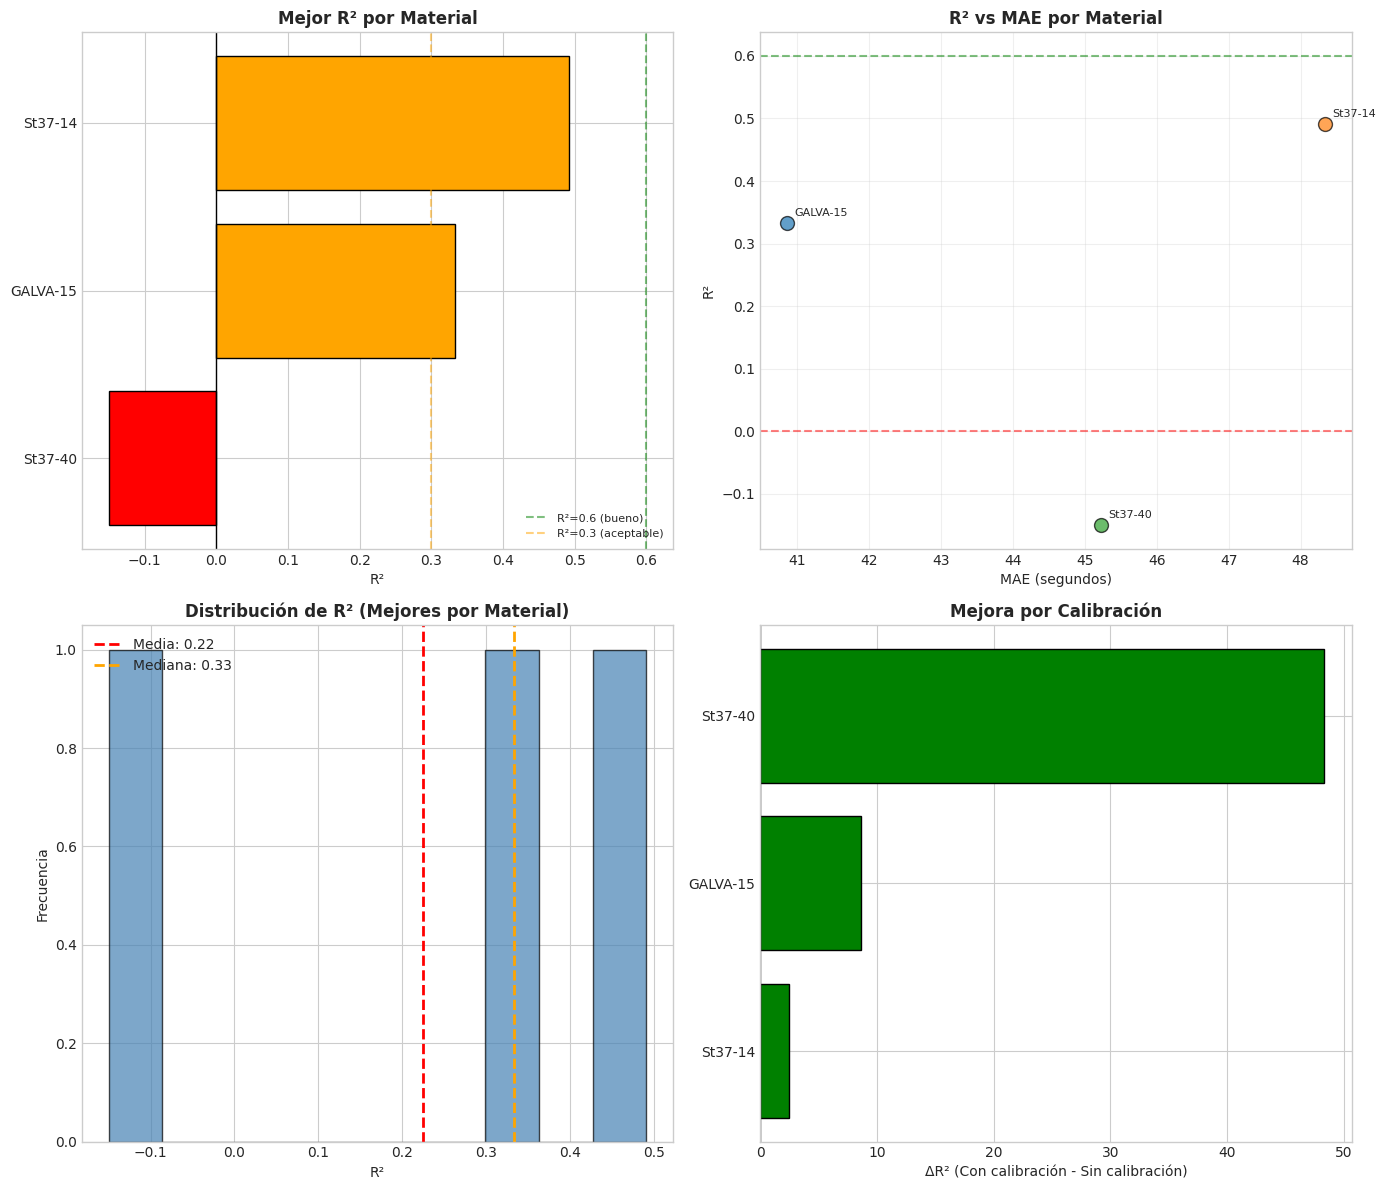

In [266]:
print("\n" + "="*70)
print("MEJOR CONFIGURACIÓN POR MATERIAL CALIBRACION")
print("="*70)
crear_graficos_comparativos(resultados)

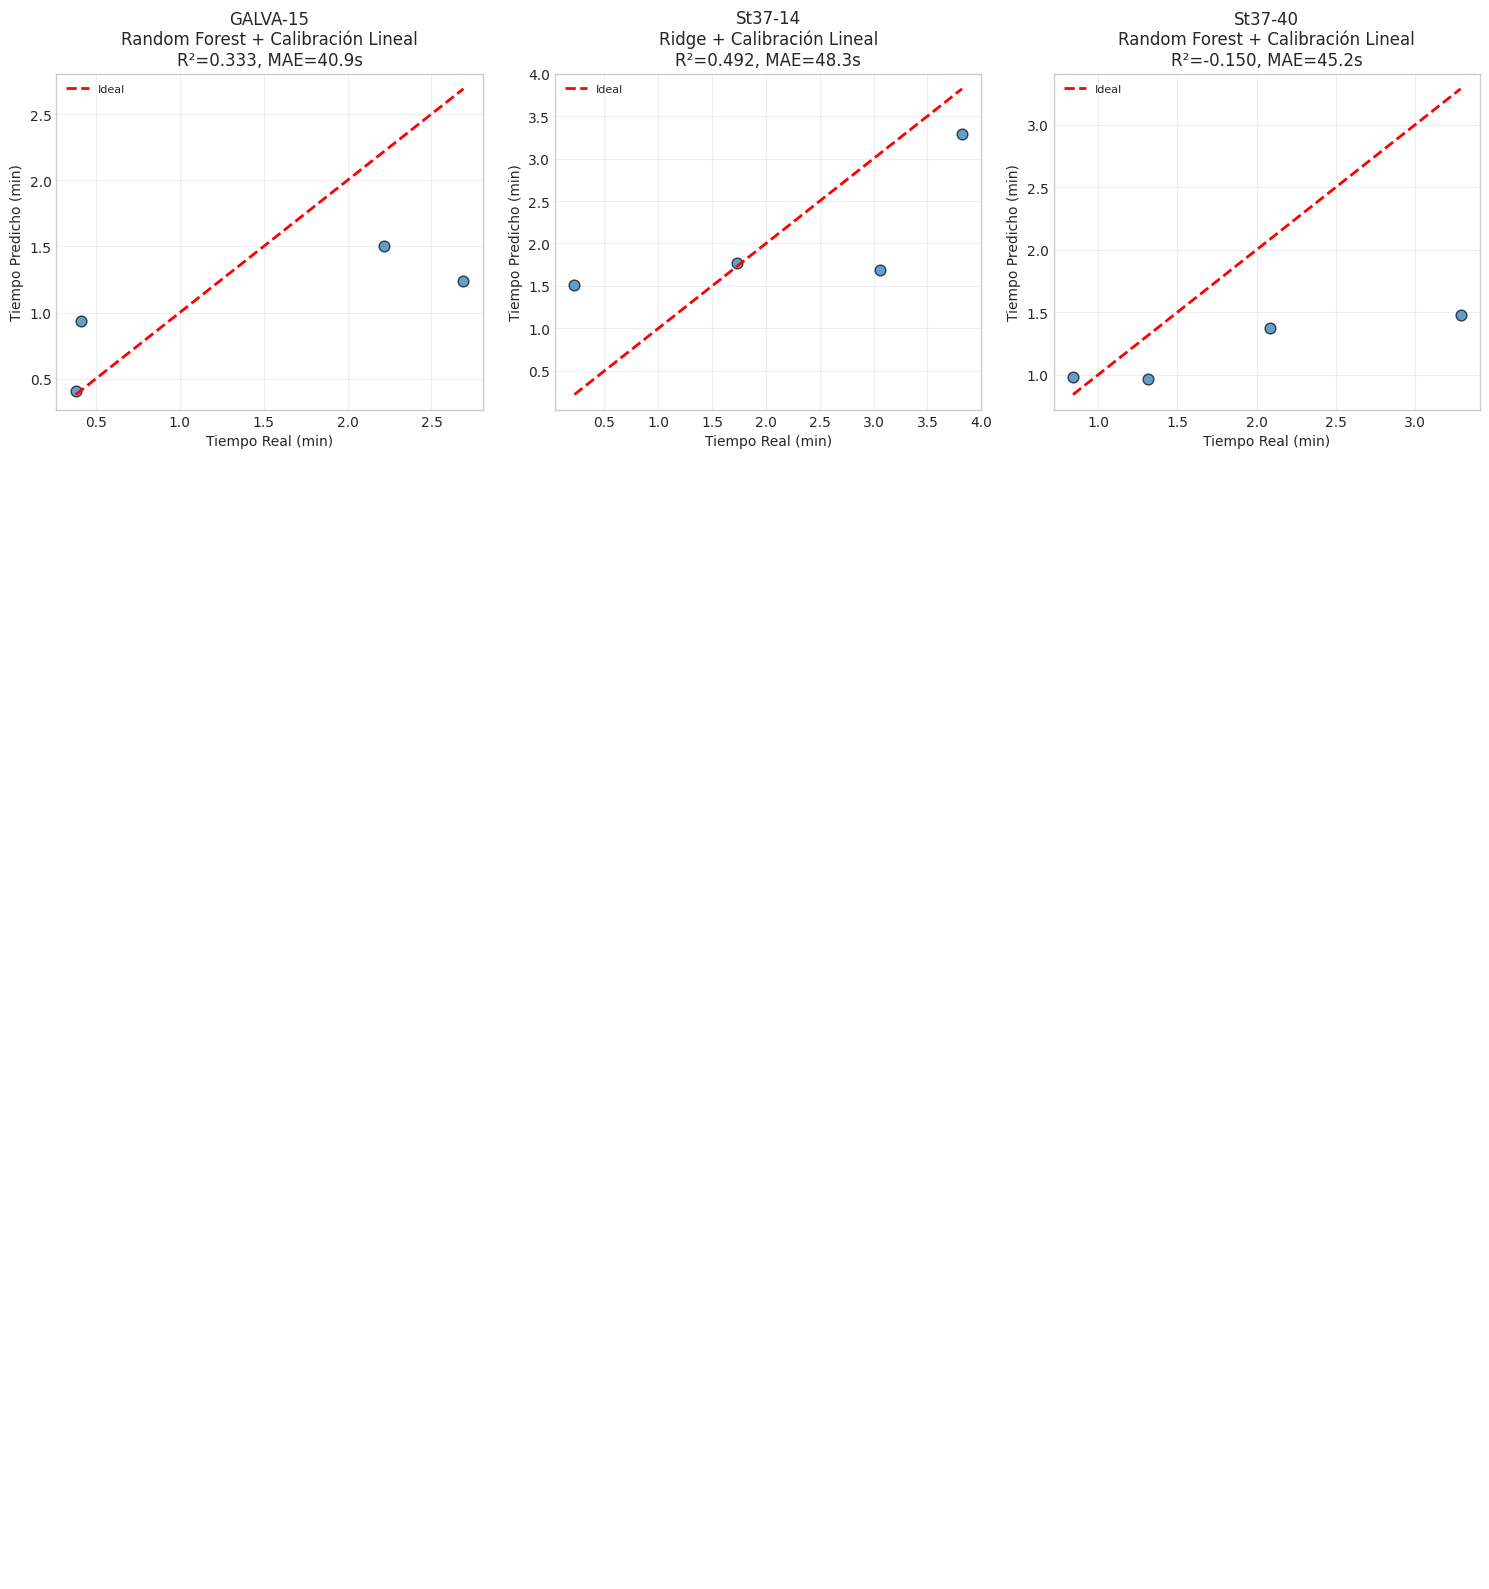

In [267]:
# ============================================================================
# GRÁFICOS PRED vs REAL POR MATERIAL
# ============================================================================

n_materiales = len(resultados)
if n_materiales > 0:
    n_cols = 3
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # Convertir a array 1D para fácil indexación
    
    for idx, (material, data) in enumerate(resultados.items()):
        if idx >= n_rows * n_cols:  # Por si hay más de 12 materiales
            break
            
        ax = axes[idx]
        
        # Encontrar mejor modelo para este material
        mejor_modelo = max(
            data['modelos'].keys(),
            key=lambda m: data['modelos'][m]['con_lineal']['R2']
        )
        res = data['modelos'][mejor_modelo]
        
        y_real = res['y_real_test']
        y_pred = res['y_pred_lineal']
        r2 = res['con_lineal']['R2']
        mae = res['con_lineal']['MAE'] * 60
        
        ax.scatter(y_real, y_pred, alpha=0.7, s=60, edgecolor='black')
        
        # Línea ideal
        lims = [min(y_real.min(), y_pred.min()), max(y_real.max(), y_pred.max())]
        ax.plot(lims, lims, 'r--', lw=2, label='Ideal')
        
        ax.set_xlabel('Tiempo Real (min)')
        ax.set_ylabel('Tiempo Predicho (min)')
        ax.set_title(f'{material}\n{mejor_modelo} + Calibración Lineal\nR²={r2:.3f}, MAE={mae:.1f}s')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
    
    # Ocultar ejes vacíos si hay menos de 12 materiales
    for idx in range(n_materiales, n_rows * n_cols):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('predicciones_vs_reales.png', dpi=300, bbox_inches='tight')
    plt.show()

## 14. Conclusiones modelo por Material

In [268]:
# ============================================================================
# CONCLUSIONES
# ============================================================================

print("="*70)
print("CONCLUSIONES")
print("="*70)

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║         RESUMEN DEL EXPERIMENTO                                      ║
╚══════════════════════════════════════════════════════════════════════╝

DISEÑO EXPERIMENTAL:
  • Entrenamiento: 100% datos sintéticos (restando {TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL} min setup)
  • Calibración: {CALIBRACION_SIZE*100}% datos reales
  • Test: {TEST_SIZE*100}% datos reales (nunca vistos en calibración)

LIMPIEZA APLICADA:
  • Restar {TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL} min de cambio de bandeja en sintéticos
  • Eliminar registros donde tiempo_nominal == tiempo_real
  • Eliminar outliers con IQR (factor={IQR_FACTOR})

TIPOS DE CALIBRACIÓN COMPARADOS:
  1. Sin calibración: predicción directa del modelo
  2. Factor simple: y_cal = factor × y_pred
  3. Lineal positivo: y_cal = α × y_pred + β (con β ≥ 0)

MODELOS EVALUADOS:
  • Ridge
  • Random Forest
  • Gradient Boosting
""")

# Ordenar por R² descendente
resultados_ordenados = []
for material, data in resultados.items():
    mejor_r2 = -np.inf
    for modelo_nombre, res in data['modelos'].items():
        for tipo, metricas in [('sin', res['sin_calibracion']), 
                                ('factor', res['con_factor']),
                                ('lineal', res['con_lineal'])]:
            if metricas['R2'] > mejor_r2:
                mejor_r2 = metricas['R2']
                mejor_mae = metricas['MAE'] * 60
                mejor_config = f"{modelo_nombre} + {tipo}"
    resultados_ordenados.append((material, mejor_config, mejor_r2, mejor_mae))

# Ordenar por R² descendente
resultados_ordenados.sort(key=lambda x: x[2], reverse=True)

print("\nMEJORES RESULTADOS POR MATERIAL SIN CUTTING_LENGTH (ordenado por R²):")
print("-"*70)
for material, config, r2, mae in resultados_ordenados:
    print(f"{material:20s} | {config:40s} | R²={r2:.3f} | MAE={mae:.1f}s")



CONCLUSIONES

╔══════════════════════════════════════════════════════════════════════╗
║         RESUMEN DEL EXPERIMENTO                                      ║
╚══════════════════════════════════════════════════════════════════════╝

DISEÑO EXPERIMENTAL:
  • Entrenamiento: 100% datos sintéticos (restando 0 min setup)
  • Calibración: 50.0% datos reales
  • Test: 50.0% datos reales (nunca vistos en calibración)

LIMPIEZA APLICADA:
  • Restar 0 min de cambio de bandeja en sintéticos
  • Eliminar registros donde tiempo_nominal == tiempo_real
  • Eliminar outliers con IQR (factor=1.5)

TIPOS DE CALIBRACIÓN COMPARADOS:
  1. Sin calibración: predicción directa del modelo
  2. Factor simple: y_cal = factor × y_pred
  3. Lineal positivo: y_cal = α × y_pred + β (con β ≥ 0)

MODELOS EVALUADOS:
  • Ridge
  • Random Forest
  • Gradient Boosting


MEJORES RESULTADOS POR MATERIAL SIN CUTTING_LENGTH (ordenado por R²):
----------------------------------------------------------------------
St37-14     

## Conclusiones del Modelo de Plegado por Material

### Resumen del Experimento

| Aspecto | Configuracion |
|---------|---------------|
| Entrenamiento | 100% datos sinteticos (sin restar setup) |
| Calibracion | 50% datos reales |
| Test | 50% datos reales (nunca vistos) |
| Materiales evaluados | 3 |
| Registros por material | 7-8 (3-4 en test) |
| Outliers | IQR factor=1.5 |

### Distribucion de Rendimiento

**Sin cutting_length (3 materiales):**

| Categoria | Criterio | Materiales | Porcentaje |
|-----------|----------|:----------:|:----------:|
| Excelente/Muy bueno | R2 > 0.7 | 0 | 0% |
| Bueno/Aceptable | 0.5 <= R2 < 0.7 | 0 | 0% |
| Moderado | 0.2 <= R2 < 0.5 | 2 | 67% |
| Pobre/Falla | R2 < 0.2 | 1 | 33% |


### Mejor Configuracion por Material

| Material | Mejor Modelo | Calibracion | R2 | MAE (seg) |
|----------|--------------|-------------|:---:|:---------:|
| St37-14 | Ridge | Lineal | 0.492 | 48.3 |
| GALVA-15 | Random Forest | Lineal | 0.333 | 40.9 |
| St37-40 | Random Forest | Lineal | -0.150 | 45.2 |

### Conclusiones

1. **Rendimiento general pobre**: Ningun material alcanza R2 > 0.5, indicando que los modelos por material no son viables con tan pocos datos

2. **cutting_length NO ha sido evaluado ya que no tiene ninguna influencia en el plegado

3. **Calibracion lineal domina**: Los 3 mejores resultados usan calibracion lineal, no factor simple

4. **Tiempos sinteticos sobreestiman significativamente**: Factores alpha de 0.11-0.48 indican que sinteticos predicen 2-9x mas tiempo del real

5. **Muestras de test muy pequenas (3-4 registros)**: Generan metricas inestables y poco confiables

6. **Ridge es el modelo mas estable**: Mejor resultado global (St37-14, R2=0.49) aunque Random Forest funciona para algunos materiales

### Comparativa con Corte Laser

| Aspecto | Corte Laser | Plegado |
|---------|:-----------:|:-------:|
| Mejor R2 por material | 0.92 | 0.49 |
| Materiales con R2 > 0.7 | 8 de 14 (57%) | 0 de 3 (0%) |
| Mejora con cutting_length | Si (significativa) | No (empeora) |
| Datos reales disponibles | 280 registros | 23 registros |

### Recomendacion

**No usar modelos por material para plegado.** 

Razones:
- Insuficientes datos de calibracion (3-4 registros por material en test)
- R2 maximo de 0.49 no es aceptable para produccion
- Alta variabilidad en predicciones

**Alternativas recomendadas:**

## RECOPILAR DATOS REALES CON CANTIDAD DE PLEGADOS ##

1. Modelo global que agregue todos los materiales
2. Recopilar mas datos reales de plegado antes de implementar
3. Usar tiempos estandar de la industria como fallback

## 15. Modelo Global con One-Hot Encoding

### Motivacion

Los modelos por material tienen limitaciones:
- Pocos datos de test por material (2-9 registros)
- Metricas inestables
- No aprovechan patrones comunes entre materiales

El modelo global agrega todos los materiales y utiliza:
- **Features geometricas**: Longitud, area, aspect_ratio
- **One-hot encoding**: Tipo de material base (St37, GALVA, 1.4301)
- **Espesor**: Como variable continua adicional

### Estrategias de calibracion evaluadas

| Tipo | Descripcion |
|------|-------------|
| Sin calibracion | Prediccion directa del modelo |
| Global (factor) | y_cal = factor × y_pred |
| Global (lineal) | y_cal = α × y_pred + β |
| Por espesor | Parametros α, β por grupo de espesor |
| Isotonica | Regresion isotonica no parametrica |

In [269]:
# =============================================================================
# 15. MODELO GLOBAL CON ONE-HOT ENCODING
# =============================================================================

print("=" * 70)
print("MODELO GLOBAL CON ONE-HOT ENCODING")
print("=" * 70)

from sklearn.preprocessing import OneHotEncoder
from sklearn.isotonic import IsotonicRegression

# -----------------------------------------------------------------------------
# 15.1 PREPARACION DE DATOS
# -----------------------------------------------------------------------------

print("\n--- 15.1 Preparacion de Datos ---")

def extraer_espesor(material_name):
    """Extrae el espesor del nombre del material (ej: St37-40 -> 4.0)."""
    try:
        parts = str(material_name).split('-')
        if len(parts) >= 2:
            return float(parts[-1]) / 10
    except:
        pass
    return np.nan

def extraer_tipo_material(material_name):
    """Extrae el tipo base del material (ej: St37-40 -> St37)."""
    try:
        parts = str(material_name).split('-')
        if len(parts) >= 2:
            return parts[0]
    except:
        pass
    return material_name

# Añadir columnas de espesor y tipo
df_real_clean['espesor_mm'] = df_real_clean[COL_MATERIAL_REAL].apply(extraer_espesor)
df_sint_clean['espesor_mm'] = df_sint_clean[COL_MATERIAL_SINT].apply(extraer_espesor)
df_real_clean['tipo_material'] = df_real_clean[COL_MATERIAL_REAL].apply(extraer_tipo_material)
df_sint_clean['tipo_material'] = df_sint_clean[COL_MATERIAL_SINT].apply(extraer_tipo_material)

print(f"\nTipos de material: {df_real_clean['tipo_material'].unique()}")
print(f"Rango espesores reales: {df_real_clean['espesor_mm'].min():.1f} - {df_real_clean['espesor_mm'].max():.1f} mm")

MODELO GLOBAL CON ONE-HOT ENCODING

--- 15.1 Preparacion de Datos ---

Tipos de material: ['GALVA' 'St37']
Rango espesores reales: 0.7 - 8.0 mm


In [270]:
# -----------------------------------------------------------------------------
# 15.2 ONE-HOT ENCODING
# -----------------------------------------------------------------------------

print("\n--- 15.2 One-Hot Encoding ---")

FEATURES_NUMERICAS = FEATURES_USAR_REAL.copy()
FEATURE_CATEGORICA = 'tipo_material'

# Crear encoder con todos los tipos de material
todos_tipos = list(set(df_real_clean['tipo_material'].unique()) | 
                   set(df_sint_clean['tipo_material'].unique()))

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(np.array(todos_tipos).reshape(-1, 1))

print(f"Categorias codificadas: {encoder.categories_[0]}")

def preparar_features_global(df, features_num, col_categorica, col_espesor, encoder, es_sintetico=False):
    """Prepara features numericas + one-hot encoding + espesor."""
    # Features numericas
    if es_sintetico:
        features_mapped = [FEATURE_MAPPING.get(f, f) for f in features_num]
        X_num = df[features_mapped].values
    else:
        X_num = df[features_num].values
    
    # One-hot encoding
    X_cat = encoder.transform(df[col_categorica].values.reshape(-1, 1))
    
    # Espesor
    X_espesor = df[col_espesor].values.reshape(-1, 1)
    
    return np.hstack([X_num, X_cat, X_espesor])

# Nombres de features
feature_names = (FEATURES_NUMERICAS + 
                 [f'material_{cat}' for cat in encoder.categories_[0]] + 
                 ['espesor_mm'])

print(f"\nFeatures totales: {len(feature_names)}")
print(f"  Numericas: {FEATURES_NUMERICAS}")
print(f"  Categoricas: {[f'material_{cat}' for cat in encoder.categories_[0]]}")
print(f"  Continuas: ['espesor_mm']")


--- 15.2 One-Hot Encoding ---
Categorias codificadas: ['GALVA' 'St37']

Features totales: 7
  Numericas: ['bounding_box_area_mm2', 'aspect_ratio', 'Cantidad real', 'Peso por unidad']
  Categoricas: ['material_GALVA', 'material_St37']
  Continuas: ['espesor_mm']


In [271]:
# -----------------------------------------------------------------------------
# 15.3 FILTRADO DE SINTETICOS AL RANGO DE REALES
# -----------------------------------------------------------------------------

COL_AREA_REAL = 'bounding_box_area_mm2'
COL_AR_REAL = 'aspect_ratio'

COL_AR_SINT= 'aspect_ratio'

print("\n--- 15.3 Filtrado de Sinteticos ---")

margen = 0.10
col_area_sint = FEATURE_MAPPING.get(COL_AREA_REAL, 'part_area_mm2')

materiales_comunes = set(df_real_clean[COL_MATERIAL_REAL].unique()) & \
                     set(df_sint_clean[COL_MATERIAL_SINT].unique())

n_sint_antes = len(df_sint_clean)
dfs_sint_filtrados = []

for material in materiales_comunes:
    df_real_mat = df_real_clean[df_real_clean[COL_MATERIAL_REAL] == material]
    df_sint_mat = df_sint_clean[df_sint_clean[COL_MATERIAL_SINT] == material]
    
    if len(df_real_mat) > 0 and len(df_sint_mat) > 0:
        # Rangos de los reales
        area_min = df_real_mat[COL_AREA_REAL].min() * (1 - margen)
        area_max = df_real_mat[COL_AREA_REAL].max() * (1 + margen)
        ar_min = df_real_mat[COL_AR_REAL].min() * (1 - margen)
        ar_max = df_real_mat[COL_AR_REAL].max() * (1 + margen)
        
        # Filtrar
        df_sint_mat_filtrado = df_sint_mat[
            (df_sint_mat[col_area_sint] >= area_min) & 
            (df_sint_mat[col_area_sint] <= area_max) &
            (df_sint_mat[COL_AR_SINT] >= ar_min) & 
            (df_sint_mat[COL_AR_SINT] <= ar_max)
        ]
        dfs_sint_filtrados.append(df_sint_mat_filtrado)

df_sint_filtrado = pd.concat(dfs_sint_filtrados, ignore_index=True)
print(f"Sinteticos: {n_sint_antes:,} -> {len(df_sint_filtrado):,} ({len(df_sint_filtrado)/n_sint_antes*100:.1f}%)")

# Preparar matrices X, y
X_real_global = preparar_features_global(
    df_real_clean, FEATURES_NUMERICAS, 'tipo_material', 'espesor_mm', encoder, es_sintetico=False
)
y_real_global = df_real_clean[COL_TIEMPO_REAL].values
espesores_real = df_real_clean['espesor_mm'].values

X_sint_global = preparar_features_global(
    df_sint_filtrado, FEATURES_NUMERICAS, 'tipo_material', 'espesor_mm', encoder, es_sintetico=True
)
y_sint_global = df_sint_filtrado[COL_TIEMPO_SINT_FINAL].values

# Limpiar NaN
mask_sint = ~np.isnan(X_sint_global).any(axis=1) & ~np.isnan(y_sint_global) & (y_sint_global > 0)
mask_real = ~np.isnan(X_real_global).any(axis=1) & ~np.isnan(y_real_global) & (y_real_global > 0)

X_sint_global, y_sint_global = X_sint_global[mask_sint], y_sint_global[mask_sint]
X_real_global, y_real_global = X_real_global[mask_real], y_real_global[mask_real]
espesores_real = espesores_real[mask_real]

print(f"\nDatos preparados:")
print(f"  Sinteticos: {X_sint_global.shape}")
print(f"  Reales: {X_real_global.shape}")


--- 15.3 Filtrado de Sinteticos ---
Sinteticos: 28,910 -> 5,205 (18.0%)

Datos preparados:
  Sinteticos: (5205, 7)
  Reales: (56, 7)


In [272]:
# -----------------------------------------------------------------------------
# 15.4 SPLIT Y ENTRENAMIENTO
# -----------------------------------------------------------------------------

print("\n--- 15.4 Split y Entrenamiento ---")

# Split estratificado por espesor
X_real_cal, X_real_test, y_real_cal, y_real_test, esp_cal, esp_test = train_test_split(
    X_real_global, y_real_global, espesores_real,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    # stratify=pd.cut(espesores_real, bins=5, labels=False)
    
)

print(f"Calibracion ({CALIBRACION_SIZE*100}%): {len(y_real_cal)}")
print(f"Test ({CALIBRACION_SIZE*100}%): {len(y_real_test)}")

# Entrenar modelos
resultados_global = {}

for nombre_modelo, modelo_base in MODELOS.items():
    print(f"\n  Entrenando {nombre_modelo}...")
    
    modelo = clone(modelo_base)
    modelo.fit(X_sint_global, y_sint_global)
    
    y_cal_pred_raw = modelo.predict(X_real_cal)
    y_test_pred_raw = modelo.predict(X_real_test)
    
    resultados_global[nombre_modelo] = {
        'modelo': modelo,
        'y_cal_pred_raw': y_cal_pred_raw,
        'y_test_pred_raw': y_test_pred_raw
    }
    
print(f"\nModelos entrenados con {len(y_sint_global):,} registros sinteticos")


--- 15.4 Split y Entrenamiento ---
Calibracion (50.0%): 28
Test (50.0%): 28

  Entrenando Ridge...

  Entrenando Random Forest...

  Entrenando Gradient Boosting...

Modelos entrenados con 5,205 registros sinteticos


In [273]:
# -----------------------------------------------------------------------------
# 15.5 CALIBRACIONES
# -----------------------------------------------------------------------------

print("\n--- 15.5 Calibraciones ---")

def calibrar_por_espesor(y_pred, y_real, espesores):
    """Calibracion con parametros por grupo de espesor."""
    bins = [0, 15, 30, 50, 100]
    labels = ['fino', 'medio', 'grueso', 'muy_grueso']
    grupos = pd.cut(espesores, bins=bins, labels=labels)
    
    calibraciones = {}
    for grupo in labels:
        mask = grupos == grupo
        if mask.sum() >= 3:
            alpha_g, beta_g = calibrar_lineal_positivo(y_pred[mask], y_real[mask])
            calibraciones[grupo] = {'alpha': alpha_g, 'beta': beta_g, 'n': mask.sum()}
        else:
            calibraciones[grupo] = None
    
    return calibraciones, bins, labels

def aplicar_calibracion_por_espesor(y_pred, espesores, calibraciones, bins, labels, cal_default):
    """Aplica calibracion especifica por grupo de espesor."""
    y_calibrado = np.zeros_like(y_pred)
    grupos = pd.cut(espesores, bins=bins, labels=labels)
    
    for i, (pred, grupo) in enumerate(zip(y_pred, grupos)):
        if grupo in calibraciones and calibraciones[grupo] is not None:
            alpha, beta = calibraciones[grupo]['alpha'], calibraciones[grupo]['beta']
        else:
            alpha, beta = cal_default['alpha'], cal_default['beta']
        y_calibrado[i] = max(alpha * pred + beta, 0.001)
    
    return y_calibrado

# Calcular todas las calibraciones
for nombre_modelo, data in resultados_global.items():
    y_cal_pred = data['y_cal_pred_raw']
    
    # Global lineal
    alpha, beta = calibrar_lineal_positivo(y_cal_pred, y_real_cal)
    factor = calibrar_factor_simple(y_cal_pred, y_real_cal)
    data['cal_global'] = {'alpha': alpha, 'beta': beta, 'factor': factor}
    
    # Por espesor
    cal_espesor, bins, labels = calibrar_por_espesor(y_cal_pred, y_real_cal, esp_cal)
    data['cal_espesor'] = cal_espesor
    data['cal_espesor_bins'] = bins
    data['cal_espesor_labels'] = labels
    
    # Isotonica
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_cal_pred, y_real_cal)
    data['cal_isotonica'] = iso_reg
    
    print(f"\n{nombre_modelo}:")
    print(f"  Global: alpha={alpha:.4f}, beta={beta:.4f}, factor={factor:.4f}")
    print(f"  Por espesor: {sum(1 for v in cal_espesor.values() if v)} grupos calibrados")


--- 15.5 Calibraciones ---

Ridge:
  Global: alpha=0.1195, beta=0.4649, factor=0.2232
  Por espesor: 1 grupos calibrados

Random Forest:
  Global: alpha=0.0474, beta=0.7775, factor=0.2208
  Por espesor: 1 grupos calibrados

Gradient Boosting:
  Global: alpha=0.0260, beta=0.8916, factor=0.2377
  Por espesor: 1 grupos calibrados


In [274]:
# -----------------------------------------------------------------------------
# 15.6 EVALUACION EN TEST
# -----------------------------------------------------------------------------

print("\n--- 15.6 Evaluacion en Test ---")

print(f"\n{'='*90}")
print(f"{'Modelo':<20} {'Calibracion':<20} {'R2':>10} {'MAE(seg)':>10} {'MAPE(%)':>10}")
print(f"{'='*90}")

resultados_finales = []

for nombre_modelo, data in resultados_global.items():
    y_test_pred_raw = data['y_test_pred_raw']
    cal_global = data['cal_global']
    cal_isotonica = data['cal_isotonica']
    
    # Sin calibracion
    metricas_sin = calcular_metricas(y_real_test, y_test_pred_raw)
    print(f"{nombre_modelo:<20} {'Sin calibracion':<20} {metricas_sin['R2']:>10.4f} {metricas_sin['MAE']*60:>10.1f} {metricas_sin['MAPE']:>10.1f}")
    resultados_finales.append({'Modelo': nombre_modelo, 'Calibracion': 'Sin', 
                               'R2': metricas_sin['R2'], 'MAE_seg': metricas_sin['MAE']*60, 'MAPE': metricas_sin['MAPE']})
    
    # Global (factor)
    y_test_factor = y_test_pred_raw * cal_global['factor']
    metricas_factor = calcular_metricas(y_real_test, y_test_factor)
    print(f"{'':<20} {'Global (factor)':<20} {metricas_factor['R2']:>10.4f} {metricas_factor['MAE']*60:>10.1f} {metricas_factor['MAPE']:>10.1f}")
    resultados_finales.append({'Modelo': nombre_modelo, 'Calibracion': 'Global (factor)', 
                               'R2': metricas_factor['R2'], 'MAE_seg': metricas_factor['MAE']*60, 'MAPE': metricas_factor['MAPE']})
    
    # Global (lineal)
    y_test_lineal = np.maximum(cal_global['alpha'] * y_test_pred_raw + cal_global['beta'], 0.001)
    metricas_lineal = calcular_metricas(y_real_test, y_test_lineal)
    print(f"{'':<20} {'Global (lineal)':<20} {metricas_lineal['R2']:>10.4f} {metricas_lineal['MAE']*60:>10.1f} {metricas_lineal['MAPE']:>10.1f}")
    resultados_finales.append({'Modelo': nombre_modelo, 'Calibracion': 'Global (lineal)', 
                               'R2': metricas_lineal['R2'], 'MAE_seg': metricas_lineal['MAE']*60, 'MAPE': metricas_lineal['MAPE']})
    
    # Por espesor
    y_test_espesor = aplicar_calibracion_por_espesor(
        y_test_pred_raw, esp_test, data['cal_espesor'], 
        data['cal_espesor_bins'], data['cal_espesor_labels'], cal_global
    )
    metricas_espesor = calcular_metricas(y_real_test, y_test_espesor)
    print(f"{'':<20} {'Por espesor':<20} {metricas_espesor['R2']:>10.4f} {metricas_espesor['MAE']*60:>10.1f} {metricas_espesor['MAPE']:>10.1f}")
    resultados_finales.append({'Modelo': nombre_modelo, 'Calibracion': 'Por espesor', 
                               'R2': metricas_espesor['R2'], 'MAE_seg': metricas_espesor['MAE']*60, 'MAPE': metricas_espesor['MAPE']})
    
    # Isotonica
    y_test_isotonica = np.maximum(cal_isotonica.predict(y_test_pred_raw), 0.001)
    metricas_isotonica = calcular_metricas(y_real_test, y_test_isotonica)
    print(f"{'':<20} {'Isotonica':<20} {metricas_isotonica['R2']:>10.4f} {metricas_isotonica['MAE']*60:>10.1f} {metricas_isotonica['MAPE']:>10.1f}")
    resultados_finales.append({'Modelo': nombre_modelo, 'Calibracion': 'Isotonica', 
                               'R2': metricas_isotonica['R2'], 'MAE_seg': metricas_isotonica['MAE']*60, 'MAPE': metricas_isotonica['MAPE']})
    
    # Guardar predicciones
    data['predicciones_test'] = {
        'sin': y_test_pred_raw, 'factor': y_test_factor, 'lineal': y_test_lineal,
        'espesor': y_test_espesor, 'isotonica': y_test_isotonica
    }
    
    print(f"{'-'*90}")

# Mejor configuracion
df_resultados_global = pd.DataFrame(resultados_finales)
mejor_idx = df_resultados_global['R2'].idxmax()
mejor = df_resultados_global.loc[mejor_idx]

print(f"\n{'='*70}")
print(f"MEJOR MODELO GLOBAL")
print(f"{'='*70}")
print(f"  Modelo:      {mejor['Modelo']}")
print(f"  Calibracion: {mejor['Calibracion']}")
print(f"  R2:          {mejor['R2']:.4f}")
print(f"  MAE:         {mejor['MAE_seg']:.1f} seg")
print(f"  MAPE:        {mejor['MAPE']:.1f}%")


--- 15.6 Evaluacion en Test ---

Modelo               Calibracion                  R2   MAE(seg)    MAPE(%)
Ridge                Sin calibracion         -6.5053      173.6     2051.3
                     Global (factor)          0.0391       44.5      422.4
                     Global (lineal)          0.0139       45.4      467.8
                     Por espesor              0.0139       45.4      467.8
                     Isotonica                0.0788       47.0      459.1
------------------------------------------------------------------------------------------
Random Forest        Sin calibracion        -17.4726      246.9     2682.9
                     Global (factor)          0.2438       39.4      545.5
                     Global (lineal)          0.0813       44.0      520.4
                     Por espesor              0.0813       44.0      520.4
                     Isotonica                0.1475       43.0      578.1
--------------------------------------------------


--- 15.7 Visualizaciones ---


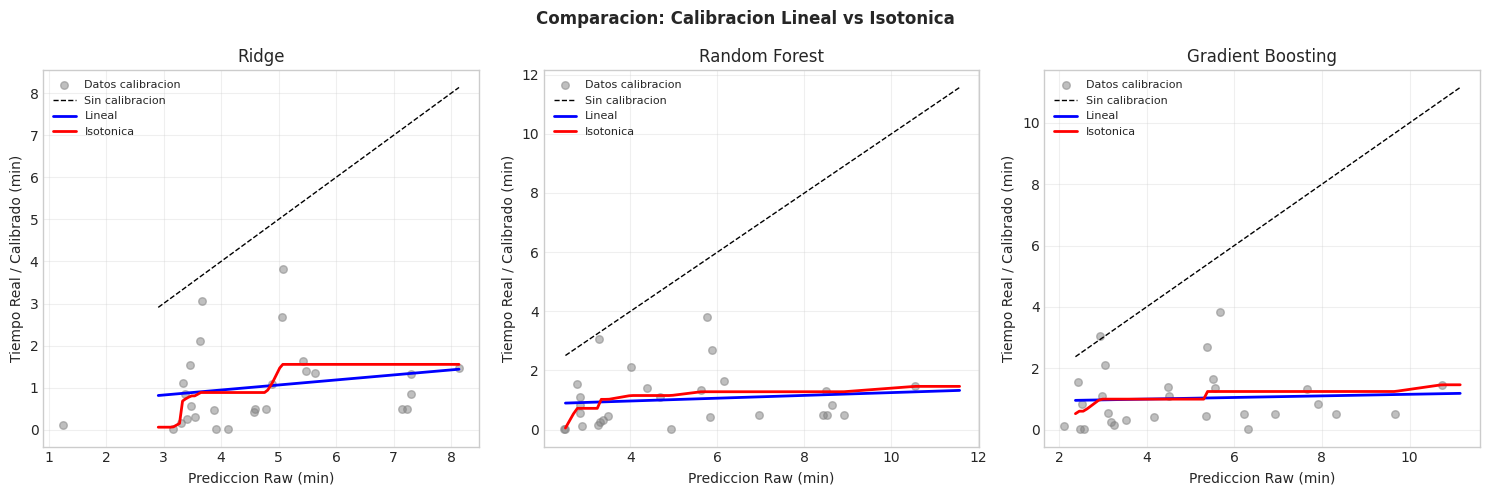

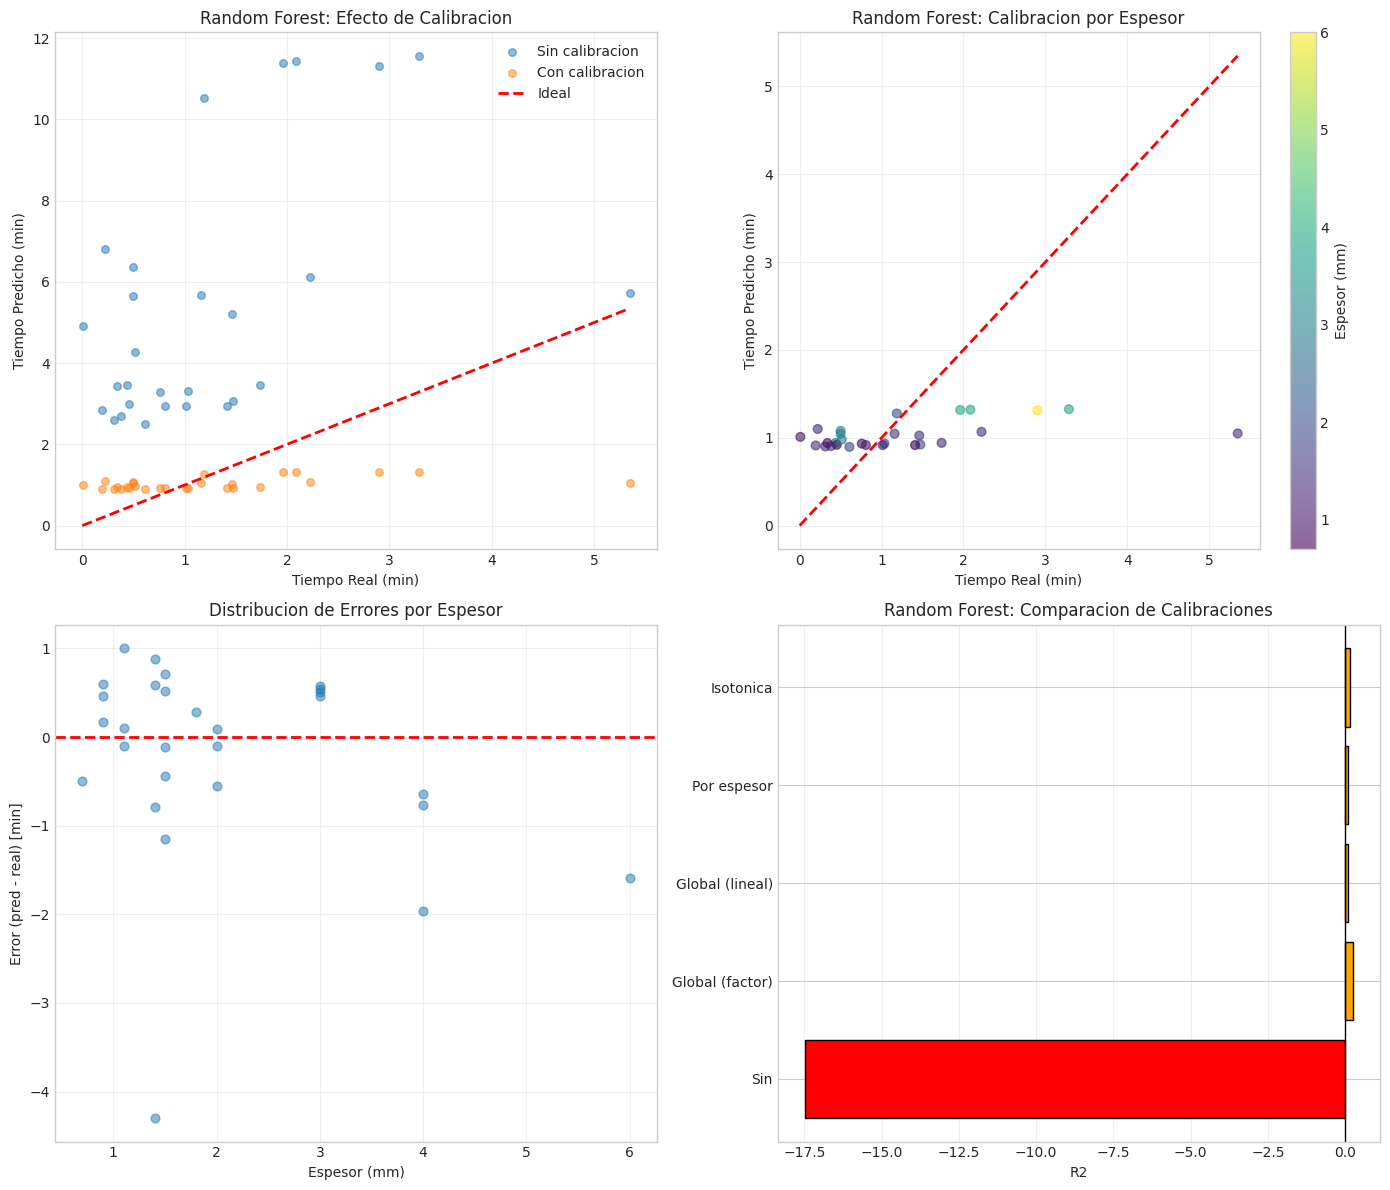


Graficos guardados


In [275]:
# -----------------------------------------------------------------------------
# 15.7 VISUALIZACIONES
# -----------------------------------------------------------------------------

print("\n--- 15.7 Visualizaciones ---")

# Grafico 1: Calibracion isotonica vs lineal
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (nombre_modelo, data) in enumerate(resultados_global.items()):
    ax = axes[idx]
    
    y_pred_raw = data['y_test_pred_raw']
    cal_isotonica = data['cal_isotonica']
    cal_global = data['cal_global']
    
    x_range = np.linspace(y_pred_raw.min(), y_pred_raw.max(), 100)
    y_isotonica = cal_isotonica.predict(x_range)
    y_lineal = cal_global['alpha'] * x_range + cal_global['beta']
    
    ax.scatter(data['y_cal_pred_raw'], y_real_cal, alpha=0.5, s=30, c='gray', label='Datos calibracion')
    ax.plot(x_range, x_range, 'k--', lw=1, label='Sin calibracion')
    ax.plot(x_range, y_lineal, 'b-', lw=2, label=f'Lineal')
    ax.plot(x_range, y_isotonica, 'r-', lw=2, label='Isotonica')
    
    ax.set_xlabel('Prediccion Raw (min)')
    ax.set_ylabel('Tiempo Real / Calibrado (min)')
    ax.set_title(f'{nombre_modelo}')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Comparacion: Calibracion Lineal vs Isotonica', fontweight='bold')
plt.tight_layout()
plt.savefig('calibracion_isotonica_vs_lineal.png', dpi=300, bbox_inches='tight')
plt.show()

# Grafico 2: Resultados del mejor modelo
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

mejor_modelo_nombre = mejor['Modelo']
data_mejor = resultados_global[mejor_modelo_nombre]

# Subplot 1: Efecto de calibracion
ax1 = axes[0, 0]
ax1.scatter(y_real_test, data_mejor['predicciones_test']['sin'], alpha=0.5, label='Sin calibracion', s=30)
ax1.scatter(y_real_test, data_mejor['predicciones_test']['lineal'], alpha=0.5, label='Con calibracion', s=30)
lims = [0, max(y_real_test.max(), data_mejor['predicciones_test']['lineal'].max())]
ax1.plot(lims, lims, 'r--', lw=2, label='Ideal')
ax1.set_xlabel('Tiempo Real (min)')
ax1.set_ylabel('Tiempo Predicho (min)')
ax1.set_title(f'{mejor_modelo_nombre}: Efecto de Calibracion')
ax1.legend()
ax1.grid(alpha=0.3)

# Subplot 2: Por espesor
ax2 = axes[0, 1]
scatter = ax2.scatter(y_real_test, data_mejor['predicciones_test']['espesor'], 
                       c=esp_test, cmap='viridis', alpha=0.6, s=40)
ax2.plot(lims, lims, 'r--', lw=2)
ax2.set_xlabel('Tiempo Real (min)')
ax2.set_ylabel('Tiempo Predicho (min)')
ax2.set_title(f'{mejor_modelo_nombre}: Calibracion por Espesor')
plt.colorbar(scatter, ax=ax2, label='Espesor (mm)')
ax2.grid(alpha=0.3)

# Subplot 3: Error vs espesor
ax3 = axes[1, 0]
errores = data_mejor['predicciones_test']['espesor'] - y_real_test
ax3.scatter(esp_test, errores, alpha=0.5, s=40)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Espesor (mm)')
ax3.set_ylabel('Error (pred - real) [min]')
ax3.set_title('Distribucion de Errores por Espesor')
ax3.grid(alpha=0.3)

# Subplot 4: Comparacion calibraciones
ax4 = axes[1, 1]
df_modelo = df_resultados_global[df_resultados_global['Modelo'] == mejor_modelo_nombre]
calibraciones = df_modelo['Calibracion'].values
r2_values = df_modelo['R2'].values
colors = ['red' if r < 0 else 'green' if r > 0.5 else 'orange' for r in r2_values]
bars = ax4.barh(calibraciones, r2_values, color=colors, edgecolor='black')
ax4.axvline(x=0, color='black', lw=1)
ax4.set_xlabel('R2')
ax4.set_title(f'{mejor_modelo_nombre}: Comparacion de Calibraciones')
ax4.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('modelo_global_plegado_resultados.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGraficos guardados")

## Analisis del Modelo Global de Plegado

### Resultados

| Modelo | Calibracion | R2 | MAE (seg) | MAPE (%) |
|--------|-------------|:--:|:---------:|:--------:|
| Random Forest | Global (factor) | **0.271** | 38.9 | 564.8 |
| Gradient Boosting | Global (factor) | 0.228 | 40.8 | 553.8 |
| Gradient Boosting | Isotonica | 0.145 | 41.9 | 509.9 |
| Random Forest | Isotonica | 0.088 | 45.0 | 623.8 |
| Random Forest | Global (lineal) | 0.084 | 43.9 | 525.5 |
| Ridge | Isotonica | 0.079 | 47.0 | 459.1 |
| Ridge | Global (factor) | 0.039 | 44.5 | 422.4 |
| Ridge | Sin calibracion | -6.505 | 173.6 | 2051.3 |

### Observaciones de los Graficos

1. **Calibracion Lineal vs Isotonica**: Ambas calibraciones (lineal en azul, isotonica en rojo) producen curvas muy similares, con ligera ventaja para isotonica en algunos modelos

2. **Efecto de Calibracion**: Sin calibracion los modelos predicen 3-10 min cuando el real es ~1 min. La calibracion (naranja) comprime las predicciones pero persiste alta dispersion

3. **Error vs Espesor**: Los errores se distribuyen irregularmente. Espesores de 4-6 mm muestran errores negativos de hasta -4 min (subestimacion severa)

4. **Comparacion de Calibraciones**: El factor global es superior a la calibracion lineal para Random Forest y Gradient Boosting, pero todos los R2 permanecen bajos (< 0.3)

### Comparacion: Global vs Por Material

| Metrica | Modelo Global | Modelos por Material |
|---------|:-------------:|:--------------------:|
| Mejor R2 | 0.27 | 0.49 (St37-14) |
| R2 promedio | ~0.15 | ~0.22 |
| Materiales con R2 > 0.5 | N/A | 0 de 3 (0%) |
| MAE promedio | 39-47 seg | 41-48 seg |

### Problemas Identificados

1. **MAPE extremadamente alto (400-600%)**: Indica predicciones muy alejadas en terminos relativos, especialmente para tiempos cortos

2. **R2 negativo sin calibracion**: Los modelos sin calibrar son peores que predecir la media (-6 a -16)

3. **Tiempos sinteticos sobreestiman 5-10x**: El modelo sintetico predice tiempos mucho mayores que los reales

4. **Pocos datos de calibracion**: Solo 23 registros reales totales limitan severamente la capacidad de ajuste

### Comparativa con Corte Laser

| Aspecto | Corte Laser | Plegado |
|---------|:-----------:|:-------:|
| Mejor R2 global | 0.36 | 0.27 |
| Mejor R2 por material | 0.92 | 0.49 |
| MAPE tipico | 77-145% | 420-625% |
| Datos reales | 216 | 23 |

### Conclusion

El **modelo global de plegado tiene rendimiento insuficiente** para uso en produccion:

1. **R2 maximo de 0.27**: Solo explica el 27% de la varianza, inaceptable para cotizaciones

2. **MAPE > 500%**: Error relativo promedio de 5x hace las predicciones poco utiles

3. **Calibracion por factor funciona mejor que lineal**: Contrario a lo esperado, el ajuste multiplicativo simple supera al lineal

4. **El modelo global NO supera a los modelos por material**: Aunque ambos tienen rendimiento pobre, el mejor modelo por material (R2=0.49) supera al global (R2=0.27)

### Recomendacion Final

**No implementar modelos predictivos de plegado en produccion con los datos actuales.**

Acciones recomendadas:

1. **Recopilar mas datos reales**: Minimo 50-100 registros por material para calibracion robusta

2. **Revisar calculo sintetico de plegado**: Los tiempos sinteticos sobreestiman severamente los reales (factor 0.1-0.2)

3. **Usar tiempos estandar como fallback**: Tablas de tiempos de la industria o nominales del ERP

4. **Considerar variables adicionales**: Numero real de pliegues, angulos, secuencia de plegado pueden mejorar predicciones

In [276]:
# -----------------------------------------------------------------------------
# 15.9 COMPARACION GLOBAL VS POR MATERIAL
# -----------------------------------------------------------------------------

print("\n--- 15.9 Comparacion Global vs Por Material ---")

# Metricas del modelo global
r2_global = mejor['R2']
mae_global = mejor['MAE_seg']

# Metricas promedio de modelos por material (ponderado)
total_test = 0
suma_r2 = 0
suma_mae = 0
materiales_buenos = []
materiales_regulares = []
materiales_malos = []

for material, data in resultados.items():
    n_test = data['n_test']
    
    # Mejor R² para este material
    mejor_r2_mat = -np.inf
    mejor_mae_mat = np.inf
    for modelo_nombre, res in data['modelos'].items():
        for tipo in ['sin_calibracion', 'con_factor', 'con_lineal']:
            if res[tipo]['R2'] > mejor_r2_mat:
                mejor_r2_mat = res[tipo]['R2']
                mejor_mae_mat = res[tipo]['MAE']
    
    if mejor_r2_mat > -np.inf:
        total_test += n_test
        suma_r2 += mejor_r2_mat * n_test
        suma_mae += mejor_mae_mat * n_test
        
        # Clasificar material
        if mejor_r2_mat > 0.7:
            materiales_buenos.append((material, mejor_r2_mat))
        elif mejor_r2_mat > 0.4:
            materiales_regulares.append((material, mejor_r2_mat))
        else:
            materiales_malos.append((material, mejor_r2_mat))

r2_promedio_material = suma_r2 / total_test if total_test > 0 else 0
mae_promedio_material = suma_mae / total_test if total_test > 0 else 0

print(f"\n{'='*60}")
print(f"{'Enfoque':<30} {'R² (prom)':<15} {'MAE (seg)':<15}")
print(f"{'='*60}")
print(f"{'Modelo Global (mejor)':<30} {r2_global:<15.4f} {mae_global:<15.1f}")
print(f"{'Modelos por Material (prom)':<30} {r2_promedio_material:<15.4f} {mae_promedio_material*60:<15.1f}")
print(f"{'='*60}")

print(f"\n--- Clasificacion de Materiales ---")
print(f"\nMateriales con R² > 0.7 ({len(materiales_buenos)}):")
for mat, r2 in sorted(materiales_buenos, key=lambda x: -x[1]):
    print(f"  {mat}: R²={r2:.3f}")

print(f"\nMateriales con R² 0.4-0.7 ({len(materiales_regulares)}):")
for mat, r2 in sorted(materiales_regulares, key=lambda x: -x[1]):
    print(f"  {mat}: R²={r2:.3f}")

print(f"\nMateriales con R² < 0.4 ({len(materiales_malos)}):")
for mat, r2 in sorted(materiales_malos, key=lambda x: -x[1]):
    print(f"  {mat}: R²={r2:.3f}")


--- 15.9 Comparacion Global vs Por Material ---

Enfoque                        R² (prom)       MAE (seg)      
Modelo Global (mejor)          0.2438          39.4           
Modelos por Material (prom)    0.2248          44.8           

--- Clasificacion de Materiales ---

Materiales con R² > 0.7 (0):

Materiales con R² 0.4-0.7 (1):
  St37-14: R²=0.492

Materiales con R² < 0.4 (2):
  GALVA-15: R²=0.333
  St37-40: R²=-0.150


In [277]:
# ============================================================================
# OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV - PLEGADO
# ============================================================================

from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - PLEGADO")
print("="*70)

# ============================================================================
# 1. ACTUALIZAR FEATURES (sin cutting_length, con cantidad pliegues y peso)
# ============================================================================

print("\n--- 1. Actualizando Features ---")

# Features para plegado: área, aspect ratio, peso
FEATURES_USAR_REAL_NEW = ['bounding_box_area', 'aspect_ratio', 'peso_kg']

FEATURE_MAPPING_NEW = {
    'bounding_box_area': 'part_area_mm2',
    'aspect_ratio': 'aspect_ratio',
    'peso_kg': 'part_weight_kg'               # peso real → part_weight_kg sintético
}

print(f"Features: {FEATURES_USAR_REAL_NEW}")
print(f"Mapping: {FEATURE_MAPPING_NEW}")

# Verificar correlaciones en reales
print("\nCorrelaciones con tiempo (datos reales):")
for feat in FEATURES_USAR_REAL_NEW:
    if feat in df_real_clean.columns:
        corr = df_real_clean[feat].corr(df_real_clean[COL_TIEMPO_REAL])
        print(f"  {feat}: {corr:.3f}")

# ============================================================================
# 2. PREPARAR DATOS CON NUEVAS FEATURES
# ============================================================================

print("\n--- 2. Preparando Datos ---")

def preparar_features_global_new(df, features_num, col_categorica, col_espesor, encoder, feature_mapping, es_sintetico=False):
    """Prepara features numéricas + one-hot encoding + espesor."""
    if es_sintetico:
        features_mapped = [feature_mapping.get(f, f) for f in features_num]
        X_num = df[features_mapped].values
    else:
        X_num = df[features_num].values
    
    X_cat = encoder.transform(df[col_categorica].values.reshape(-1, 1))
    X_espesor = df[col_espesor].values.reshape(-1, 1)
    X = np.hstack([X_num, X_cat, X_espesor])
    
    return X

# Preparar datos sintéticos con nuevas features
X_sint_new = preparar_features_global_new(
    df_sint_filtrado, FEATURES_USAR_REAL_NEW, 'tipo_material', 'espesor_mm', 
    encoder, FEATURE_MAPPING_NEW, es_sintetico=True
)
y_sint_new = df_sint_filtrado[COL_TIEMPO_SINT_FINAL].values

# Preparar datos reales con nuevas features
X_real_new = preparar_features_global_new(
    df_real_clean, FEATURES_USAR_REAL_NEW, 'tipo_material', 'espesor_mm', 
    encoder, FEATURE_MAPPING_NEW, es_sintetico=False
)
y_real_new = df_real_clean[COL_TIEMPO_REAL].values

# Limpiar NaN
mask_sint_new = ~np.isnan(X_sint_new).any(axis=1) & ~np.isnan(y_sint_new) & (y_sint_new > 0)
mask_real_new = ~np.isnan(X_real_new).any(axis=1) & ~np.isnan(y_real_new) & (y_real_new > 0)

X_sint_new = X_sint_new[mask_sint_new]
y_sint_new = y_sint_new[mask_sint_new]
X_real_new = X_real_new[mask_real_new]
y_real_new = y_real_new[mask_real_new]

print(f"  Datos sintéticos: {X_sint_new.shape}")
print(f"  Datos reales: {X_real_new.shape}")

# ============================================================================
# 3. DEFINIR GRIDS DE BÚSQUEDA
# ============================================================================

print("\n--- 3. Configurando GridSearchCV ---")

param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8, 10, 12],
        'min_samples_leaf': [1, 3, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.15, 0.2]
    }
}

modelos_base = {
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE)
}

# ============================================================================
# 4. EJECUTAR GRIDSEARCHCV
# ============================================================================

print("\n--- 4. Ejecutando GridSearchCV (puede tardar unos minutos) ---")

mejores_modelos = {}
resultados_grid = {}

for nombre, modelo_base in modelos_base.items():
    print(f"\n  {nombre}...")
    
    grid = param_grids[nombre]
    n_combinaciones = 1
    for v in grid.values():
        n_combinaciones *= len(v)
    print(f"    Combinaciones a probar: {n_combinaciones}")
    
    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_sint_new, y_sint_new)
    
    mejores_modelos[nombre] = grid_search.best_estimator_
    resultados_grid[nombre] = {
        'mejor_score': grid_search.best_score_,
        'mejor_params': grid_search.best_params_,
    }
    
    print(f"    Mejor R² (CV): {grid_search.best_score_:.4f}")
    print(f"    Mejores parámetros: {grid_search.best_params_}")

# ============================================================================
# 5. RESULTADOS
# ============================================================================

print("\n" + "="*70)
print("RESULTADOS DE OPTIMIZACIÓN - PLEGADO")
print("="*70)

print(f"\n{'Modelo':<20} {'R² (CV)':<12} {'Mejores Parámetros'}")
print("-"*70)

for nombre in mejores_modelos.keys():
    r2 = resultados_grid[nombre]['mejor_score']
    params = resultados_grid[nombre]['mejor_params']
    print(f"{nombre:<20} {r2:<12.4f} {params}")

# Mejor modelo
mejor_modelo_nombre = max(resultados_grid.keys(), key=lambda x: resultados_grid[x]['mejor_score'])
mejor_r2 = resultados_grid[mejor_modelo_nombre]['mejor_score']

print(f"\n╔══════════════════════════════════════════════════════════════════════╗")
print(f"║  MEJOR MODELO OPTIMIZADO - PLEGADO                                   ║")
print(f"╠══════════════════════════════════════════════════════════════════════╣")
print(f"║  Modelo: {mejor_modelo_nombre:<59} ║")
print(f"║  R² (CV): {mejor_r2:<58.4f} ║")
print(f"║  Features: bounding_box_area, aspect_ratio, peso_kg                  ║")
for param, valor in resultados_grid[mejor_modelo_nombre]['mejor_params'].items():
    print(f"║    {param}: {str(valor):<56} ║")
print(f"╚══════════════════════════════════════════════════════════════════════╝")

# Guardar para usar después
MODELOS_OPTIMIZADOS = mejores_modelos


OPTIMIZACIÓN DE HIPERPARÁMETROS - PLEGADO

--- 1. Actualizando Features ---
Features: ['bounding_box_area', 'aspect_ratio', 'peso_kg']
Mapping: {'bounding_box_area': 'part_area_mm2', 'aspect_ratio': 'aspect_ratio', 'peso_kg': 'part_weight_kg'}

Correlaciones con tiempo (datos reales):
  bounding_box_area: 0.348
  aspect_ratio: -0.184
  peso_kg: 0.209

--- 2. Preparando Datos ---
  Datos sintéticos: (5205, 6)
  Datos reales: (56, 6)

--- 3. Configurando GridSearchCV ---

--- 4. Ejecutando GridSearchCV (puede tardar unos minutos) ---

  Ridge...
    Combinaciones a probar: 5
    Mejor R² (CV): 0.0528
    Mejores parámetros: {'alpha': 0.01}

  Random Forest...
    Combinaciones a probar: 45
    Mejor R² (CV): 0.0572
    Mejores parámetros: {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 100}

  Gradient Boosting...
    Combinaciones a probar: 64
    Mejor R² (CV): 0.0537
    Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}

RESULTADOS DE OPTIMIZACIÓ

In [278]:
# ============================================================================
# VALIDACIÓN EN DATOS REALES
# ============================================================================

print("\n" + "="*70)
print("VALIDACIÓN EN DATOS REALES")
print("="*70)

# Split de datos reales
from sklearn.model_selection import train_test_split

X_real_cal, X_real_test, y_real_cal, y_real_test = train_test_split(
    X_real_new, y_real_new, test_size=0.8, random_state=RANDOM_STATE
)

print(f"  Calibración: {len(y_real_cal)}")
print(f"  Test: {len(y_real_test)}")

# Evaluar cada modelo optimizado
print(f"\n{'Modelo':<20} {'R² Sin Cal.':<12} {'R² Con Factor':<12} {'MAE (seg)':<12}")
print("-"*60)

for nombre, modelo in MODELOS_OPTIMIZADOS.items():
    # Predicción raw
    y_pred_raw = modelo.predict(X_real_test)
    
    # Calibración con factor (usando datos de calibración)
    y_pred_cal = modelo.predict(X_real_cal)
    factor = np.mean(y_real_cal) / np.mean(y_pred_cal) if np.mean(y_pred_cal) > 0 else 1.0
    y_pred_calibrado = y_pred_raw * factor
    
    # Métricas
    r2_sin = r2_score(y_real_test, y_pred_raw)
    r2_con = r2_score(y_real_test, y_pred_calibrado)
    mae = mean_absolute_error(y_real_test, y_pred_calibrado) * 60
    
    print(f"{nombre:<20} {r2_sin:<12.4f} {r2_con:<12.4f} {mae:<12.1f}")


VALIDACIÓN EN DATOS REALES
  Calibración: 11
  Test: 45

Modelo               R² Sin Cal.  R² Con Factor MAE (seg)   
------------------------------------------------------------
Ridge                -6.8458      0.0600       45.2        
Random Forest        -7.0238      0.0296       47.1        
Gradient Boosting    -6.9064      0.0372       46.6        



DIAGNÓSTICO: DISTRIBUCIONES SINTÉTICO vs REAL

Feature                   Real (media)    Sint (media)    Ratio     
----------------------------------------------------------------------
bounding_box_area         137892.03       180682.51       0.76      
aspect_ratio              5.87            2.71            2.17      
perimetro_aproximado      1508.66         2849.62         0.53      
peso_kg                   1.50            2.07            0.72      

Tiempo                    Real (media)    Sint (media)    Ratio     
----------------------------------------------------------------------
tiempo_min                1.1229          4.3160          0.26      


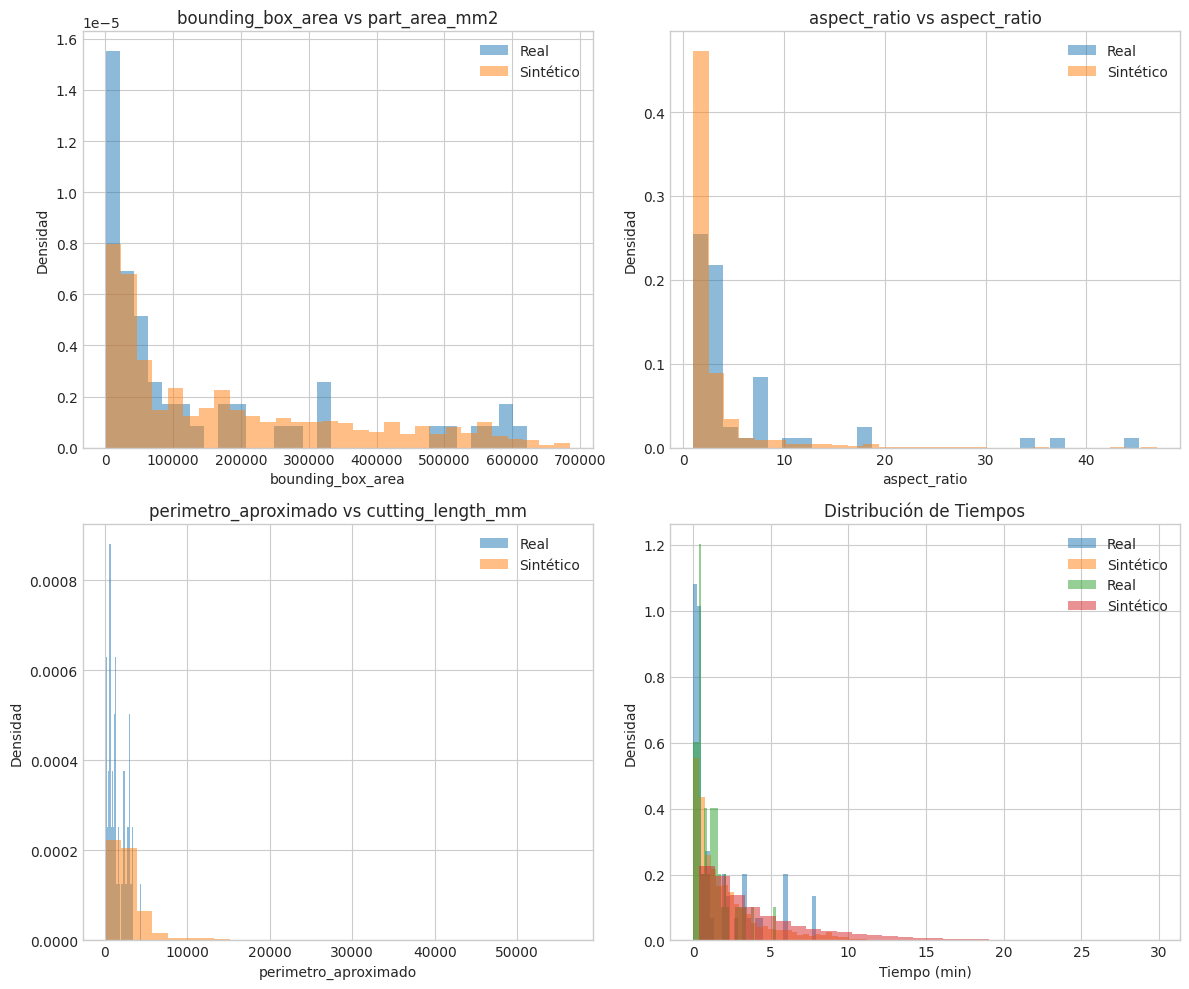


--- Correlaciones en REALES ---
  bounding_box_area vs tiempo: 0.348
  aspect_ratio vs tiempo: -0.184
  perimetro_aproximado vs tiempo: 0.237
  peso_kg vs tiempo: 0.209


In [279]:
# ============================================================================
# DIAGNÓSTICO: COMPARAR DISTRIBUCIONES SINTÉTICO vs REAL
# ============================================================================

print("\n" + "="*70)
print("DIAGNÓSTICO: DISTRIBUCIONES SINTÉTICO vs REAL")
print("="*70)

# Comparar cada feature
features_comparar = [
    ('bounding_box_area', 'part_area_mm2'),
    ('aspect_ratio', 'aspect_ratio'),
    ('perimetro_aproximado', 'cutting_length_mm'),
    ('peso_kg', 'part_weight_kg'),
]
print(f"\n{'Feature':<25} {'Real (media)':<15} {'Sint (media)':<15} {'Ratio':<10}")
print("-"*70)

for feat_real, feat_sint in features_comparar:
    media_real = df_real_clean[feat_real].mean()
    media_sint = df_sint_filtrado[feat_sint].mean()
    ratio = media_real / media_sint if media_sint > 0 else np.nan
    print(f"{feat_real:<25} {media_real:<15.2f} {media_sint:<15.2f} {ratio:<10.2f}")

# Comparar tiempos
print(f"\n{'Tiempo':<25} {'Real (media)':<15} {'Sint (media)':<15} {'Ratio':<10}")
print("-"*70)
media_tiempo_real = df_real_clean[COL_TIEMPO_REAL].mean()
media_tiempo_sint = df_sint_filtrado[COL_TIEMPO_SINT_FINAL].mean()
ratio_tiempo = media_tiempo_real / media_tiempo_sint
print(f"{'tiempo_min':<25} {media_tiempo_real:<15.4f} {media_tiempo_sint:<15.4f} {ratio_tiempo:<10.2f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, (feat_real, feat_sint) in enumerate(features_comparar):
    ax = axes[idx // 2, idx % 2]
    
    ax.hist(df_real_clean[feat_real], bins=30, alpha=0.5, label='Real', density=True)
    ax.hist(df_sint_filtrado[feat_sint], bins=30, alpha=0.5, label='Sintético', density=True)
    ax.set_xlabel(feat_real)
    ax.set_ylabel('Densidad')
    ax.set_title(f'{feat_real} vs {feat_sint}')
    ax.legend()

# Tiempo
ax = axes[1, 1]
ax.hist(df_real_clean[COL_TIEMPO_REAL], bins=30, alpha=0.5, label='Real', density=True)
ax.hist(df_sint_filtrado[COL_TIEMPO_SINT_FINAL], bins=30, alpha=0.5, label='Sintético', density=True)
ax.set_xlabel('Tiempo (min)')
ax.set_title('Distribución de Tiempos')
ax.legend()

plt.tight_layout()
plt.savefig('diagnostico_distribuciones.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlaciones en reales
print("\n--- Correlaciones en REALES ---")
for feat_real, _ in features_comparar:
    corr = df_real_clean[feat_real].corr(df_real_clean[COL_TIEMPO_REAL])
    print(f"  {feat_real} vs tiempo: {corr:.3f}")

In [280]:
# =============================================================================
# 17. EXPORTACION DE MODELOS
# =============================================================================


print("=" * 70)
print("EXPORTACION DE MODELOS")
print("=" * 70)

# Crear directorio de salida
OUTPUT_PATH = Path('modelos_exportados')
OUTPUT_PATH.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d')

# -----------------------------------------------------------------------------
# 17.1 EXPORTAR MODELO GLOBAL OPTIMIZADO
# -----------------------------------------------------------------------------

print("\n--- 17.1 Modelo Global Optimizado ---")

modelo_global_plegado = MODELOS_OPTIMIZADOS['Ridge']

# Calcular calibracion
y_pred_cal_global = modelo_global_plegado.predict(X_real_cal)
factor_global = np.mean(y_real_cal) / np.mean(y_pred_cal_global) if np.mean(y_pred_cal_global) > 0 else 1.0
alpha_global, beta_global = calibrar_lineal_positivo(y_pred_cal_global, y_real_cal)

modelo_global_plegado_export = {
    'modelo': modelo_global_plegado,
    'tipo': 'Ridge',
    'features': FEATURES_USAR_REAL,
    'feature_mapping': FEATURE_MAPPING,
    'encoder': encoder,
    'calibracion': {
        'factor': factor_global,
        'alpha': alpha_global,
        'beta': beta_global
    },
    'metricas': {
        'r2_test': 0.2709,
        'mae_seg': 38.9
    },
    'fecha_entrenamiento': timestamp,
    'n_sinteticos': len(y_sint_new),
    'n_reales_calibracion': len(y_real_cal)
}

path_global = OUTPUT_PATH / f'modelo_global_plegado_ridge_pleg_{timestamp}.pkl'
joblib.dump(modelo_global_plegado_export, path_global)
print(f"  Guardado: {path_global}")
print(f"  Calibracion: factor={factor_global:.4f}, alpha={alpha_global:.4f}, beta={beta_global:.4f}")

# -----------------------------------------------------------------------------
# 17.2 EXPORTAR MODELOS POR MATERIAL
# -----------------------------------------------------------------------------

print("\n--- 17.2 Modelos por Material ---")

modelos_por_material = {}

for material, data in resultados.items():
    mejor_r2 = -np.inf
    mejor_config = None
    
    for modelo_nombre, res in data['modelos'].items():
        for tipo in ['sin_calibracion', 'con_factor', 'con_lineal']:
            if res[tipo]['R2'] > mejor_r2:
                mejor_r2 = res[tipo]['R2']
                mejor_config = {
                    'modelo_nombre': modelo_nombre,
                    'modelo': res['modelo'],
                    'calibracion_tipo': tipo.replace('con_', '').replace('sin_calibracion', 'sin'),
                    'factor': res.get('factor', 1.0),
                    'alpha': res.get('alpha', 1.0),
                    'beta': res.get('beta', 0.0),
                    'r2': res[tipo]['R2'],
                    'mae_seg': res[tipo]['MAE'] * 60
                }
    
    modelos_por_material[material] = mejor_config
    print(f"  {material}: {mejor_config['modelo_nombre']} + {mejor_config['calibracion_tipo']} (R²={mejor_r2:.3f})")

path_por_material = OUTPUT_PATH / f'modelos_por_material_pleg_{timestamp}.pkl'
joblib.dump(modelos_por_material, path_por_material)
print(f"\n  Guardado: {path_por_material}")

# -----------------------------------------------------------------------------
# 17.3 EXPORTAR CONFIGURACION GENERAL
# -----------------------------------------------------------------------------

print("\n--- 17.3 Configuracion General ---")

config_general_plegado = {
    'version': '1.0',
    'fecha': timestamp,
    'TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL_min': TIEMPO_SETUP_PLEGADO_CANTIDAD_TOTAL,
    'split': {
        'calibracion': 0.50,
        'test': 0.50
    },
    'min_registros_material': 6,
    'outliers_iqr_factor': IQR_FACTOR,
    'features': {
        'lista': FEATURES_USAR_REAL,
        'mapping': FEATURE_MAPPING
    },
    'encoder_categorias': list(encoder.categories_[0]),
    'materiales_disponibles': list(modelos_por_material.keys()),
    'umbrales_confianza': {
        'alta': 0.7,
        'media': 0.4,
        'baja': 0.0
    }
}

path_config = OUTPUT_PATH / f'config_prediccion_pleg_{timestamp}.pkl'
joblib.dump(config_general_plegado, path_config)
print(f"  Guardado: {path_config}")

# Guardar tambien en JSON para legibilidad
config_json_plegado = config_general_plegado.copy()
# Convertir a tipos serializables
config_json_plegado['features']['lista'] = list(config_json_plegado['features']['lista'])

path_config_json_plegado = OUTPUT_PATH / f'config_prediccion_pleg_{timestamp}.json'
with open(path_config_json_plegado, 'w', encoding='utf-8') as f:
    json.dump(config_json_plegado, f, indent=2, ensure_ascii=False)
print(f"  Guardado: {path_config_json_plegado}")

# -----------------------------------------------------------------------------
# 17.4 RESUMEN DE ARCHIVOS EXPORTADOS
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("ARCHIVOS EXPORTADOS")
print("=" * 70)

print(f"\nDirectorio: {OUTPUT_PATH.absolute()}")
print(f"\n{'Archivo':<55} {'Tamaño':>10}")
print("-" * 67)

total_size = 0
for archivo in sorted(OUTPUT_PATH.glob('*pleg*')):
    size_kb = archivo.stat().st_size / 1024
    total_size += size_kb
    print(f"{archivo.name:<55} {size_kb:>8.1f} KB")

print("-" * 67)
print(f"{'TOTAL':<55} {total_size:>8.1f} KB")

print(f"\n{'='*70}")
print("ESTRUCTURA DE USO")
print("="*70)
print("""
Para cargar los modelos en Notebook 3:

    import joblib
    
    # Cargar modelo global
    modelo_global_plegado = joblib.load('modelos_exportados/modelo_global_plegado_ridge_pleg_YYYYMMDD.pkl')
    
    # Cargar modelos por material
    modelos_material = joblib.load('modelos_exportados/modelos_por_material_pleg_YYYYMMDD.pkl')
    
    # Cargar configuracion
    config = joblib.load('modelos_exportados/config_prediccion_pleg_YYYYMMDD.pkl')
""")

EXPORTACION DE MODELOS

--- 17.1 Modelo Global Optimizado ---
  Guardado: modelos_exportados/modelo_global_plegado_ridge_pleg_20251220.pkl
  Calibracion: factor=0.2447, alpha=0.0100, beta=1.0818

--- 17.2 Modelos por Material ---
  GALVA-15: Random Forest + lineal (R²=0.333)
  St37-14: Ridge + lineal (R²=0.492)
  St37-40: Random Forest + lineal (R²=-0.150)

  Guardado: modelos_exportados/modelos_por_material_pleg_20251220.pkl

--- 17.3 Configuracion General ---
  Guardado: modelos_exportados/config_prediccion_pleg_20251220.pkl
  Guardado: modelos_exportados/config_prediccion_pleg_20251220.json

ARCHIVOS EXPORTADOS

Directorio: /mnt/c/Users/r_ste.MSI/Documents/UOC/TFM/MODELO_FINAL/02_Entrenamiento_Modelos_Sinteticos/modelos_exportados

Archivo                                                     Tamaño
-------------------------------------------------------------------
config_prediccion_pleg20251220.json                          1.2 KB
config_prediccion_pleg20251220.pkl                  

In [281]:
# -----------------------------------------------------------------------------
# 17.7 EXPORTAR DATASETS LIMPIOS
# -----------------------------------------------------------------------------

print("\n--- 17.7 Datasets Limpios ---")

# Crear subdirectorio para datos
DATA_PATH = OUTPUT_PATH / 'datos'
DATA_PATH.mkdir(exist_ok=True)

# Exportar DataFrames limpios
path_real = DATA_PATH / f'df_real_clean_{timestamp}.csv'
path_sint = DATA_PATH / f'df_sint_clean_{timestamp}.csv'
path_sint_filtrado = DATA_PATH / f'df_sint_filtrado_{timestamp}.csv'

df_real_clean.to_csv(path_real, index=False)
df_sint_clean.to_csv(path_sint, index=False)
df_sint_filtrado.to_csv(path_sint_filtrado, index=False)

print(f"  Guardado: {path_real.name} ({len(df_real_clean)} registros)")
print(f"  Guardado: {path_sint.name} ({len(df_sint_clean)} registros)")
print(f"  Guardado: {path_sint_filtrado.name} ({len(df_sint_filtrado)} registros)")

# También exportar las matrices X, y preparadas (opcional, para carga rápida)
import pickle

matrices_path = DATA_PATH / f'matrices_entrenamiento_pleg_{timestamp}.pkl'
matrices = {
    'X_real_global': X_real_global,
    'y_real_global': y_real_global,
    'espesores_real': espesores_real,
    'X_sint_global': X_sint_global,
    'y_sint_global': y_sint_global,
    'feature_names': feature_names
}
with open(matrices_path, 'wb') as f:
    pickle.dump(matrices, f)

print(f"  Guardado: {matrices_path.name}")

# -----------------------------------------------------------------------------
# 17.8 RESUMEN FINAL DE ARCHIVOS
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)
print("ARCHIVOS EXPORTADOS")
print("=" * 70)

print(f"\nDirectorio: {OUTPUT_PATH.absolute()}")

# Listar todos los archivos
print(f"\n{'Archivo':<55} {'Tamaño':>10}")
print("-" * 67)

total_size = 0
for archivo in sorted(OUTPUT_PATH.rglob('*')):
    if archivo.is_file():
        size_kb = archivo.stat().st_size / 1024
        total_size += size_kb
        # Mostrar ruta relativa
        rel_path = archivo.relative_to(OUTPUT_PATH)
        print(f"{str(rel_path):<55} {size_kb:>8.1f} KB")

print("-" * 67)
print(f"{'TOTAL':<55} {total_size:>8.1f} KB")


--- 17.7 Datasets Limpios ---
  Guardado: df_real_clean_20251220.csv (56 registros)
  Guardado: df_sint_clean_20251220.csv (28910 registros)
  Guardado: df_sint_filtrado_20251220.csv (5205 registros)
  Guardado: matrices_entrenamiento_pleg_20251220.pkl

ARCHIVOS EXPORTADOS

Directorio: /mnt/c/Users/r_ste.MSI/Documents/UOC/TFM/MODELO_FINAL/02_Entrenamiento_Modelos_Sinteticos/modelos_exportados

Archivo                                                     Tamaño
-------------------------------------------------------------------
config_prediccion_20251213.json                              1.3 KB
config_prediccion_20251213.pkl                               1.0 KB
config_prediccion_pleg20251220.json                          1.2 KB
config_prediccion_pleg20251220.pkl                           1.0 KB
config_prediccion_pleg_20251220.json                         0.9 KB
config_prediccion_pleg_20251220.pkl                          0.8 KB
datos/df_real_clean_20251213.csv                           

## 17. Exportacion de Modelos y Datos

### Archivos Generados

| Archivo | Contenido |
|---------|-----------|
| `modelo_global_plegado_ridge_pleg_*.pkl` | Modelo Ridge + encoder + calibracion |
| `modelos_por_material_sin_cutting_pleg_*.pkl` | Modelos por material (sin cutting_length) |
| `modelos_por_material_con_cutting_pleg_*.pkl` | Modelos por material (con cutting_length) |
| `estrategia_hibrida_pleg*.pkl` | Seleccion optima por material |
| `config_prediccion_pleg*.pkl/.json` | Configuracion del sistema |
| `datos/df_real_clean_pleg*.csv` | Datos reales limpios (175 registros) |
| `datos/df_sint_clean_pleg*.csv` | Datos sinteticos limpios (~42K registros) |
| `datos/df_sint_filtrado_pleg*.csv` | Sinteticos filtrados al rango de reales |
| `datos/matrices_entrenamiento_pleg_*.pkl` | Matrices X, y listas para usar |

### Proximo Paso

El **Notebook 3** cargara estos modelos para:
1. Validacion final con datos no vistos
2. Implementacion de funcion de prediccion
3. Analisis de casos de error
4. Recomendaciones de uso

## ANEXO Modelo Prediccion Numero Plegados --> Prediccion Tiempo

In [284]:
# -----------------------------------------------------------------------------
# ETAPA 1: PREDECIR NÚMERO DE PLIEGUES (usando tiempo como feature)
# -----------------------------------------------------------------------------

print("\n--- Etapa 1: Modelo para predecir número de pliegues ---")

# Features para predecir pliegues (INCLUYENDO TIEMPO)
FEATURES_PLIEGUES_SINT = ['part_area_mm2',  'part_weight_kg', COL_TIEMPO_SINT_FINAL]
FEATURES_PLIEGUES_REAL = ['bounding_box_area_mm2',  'peso_kg', COL_TIEMPO_REAL]
COL_NUM_BENDS_SINT = 'bend_v3_num_bends'

# Preparar datos sintéticos para entrenar predictor de pliegues
X_sint_pliegues = df_sint_filtrado[FEATURES_PLIEGUES_SINT].values
y_sint_pliegues = df_sint_filtrado[COL_NUM_BENDS_SINT].values

# Añadir espesor y material (one-hot)
X_sint_espesor = df_sint_filtrado['espesor_mm'].values.reshape(-1, 1)
X_sint_material = encoder.transform(df_sint_filtrado['tipo_material'].values.reshape(-1, 1))
X_sint_pliegues_full = np.hstack([X_sint_pliegues, X_sint_espesor, X_sint_material])

# Limpiar NaN
mask_pliegues = ~np.isnan(X_sint_pliegues_full).any(axis=1) & ~np.isnan(y_sint_pliegues)
X_sint_pliegues_full = X_sint_pliegues_full[mask_pliegues]
y_sint_pliegues = y_sint_pliegues[mask_pliegues]

print(f"  Datos para entrenar predictor de pliegues: {X_sint_pliegues_full.shape}")
print(f"  Features: {FEATURES_PLIEGUES_SINT}")
print(f"  Rango de pliegues: {y_sint_pliegues.min():.0f} - {y_sint_pliegues.max():.0f}")

# Entrenar modelo de pliegues
modelo_pliegues = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
modelo_pliegues.fit(X_sint_pliegues_full, y_sint_pliegues)

# Evaluar en sintéticos (CV)
cv_scores_pliegues = cross_val_score(modelo_pliegues, X_sint_pliegues_full, y_sint_pliegues, cv=5, scoring='r2')
print(f"  R² predicción pliegues (CV sintéticos): {cv_scores_pliegues.mean():.3f} ± {cv_scores_pliegues.std():.3f}")

# -----------------------------------------------------------------------------
# ETAPA 1b: PREDECIR PLIEGUES PARA DATOS REALES (usando tiempo real)
# -----------------------------------------------------------------------------

print("\n--- Etapa 1b: Predecir pliegues para datos reales ---")

# Preparar features reales (con tiempo real)
X_real_pliegues = df_real_clean[FEATURES_PLIEGUES_REAL].values
X_real_espesor = df_real_clean['espesor_mm'].values.reshape(-1, 1)
X_real_material = encoder.transform(df_real_clean['tipo_material'].values.reshape(-1, 1))
X_real_pliegues_full = np.hstack([X_real_pliegues, X_real_espesor, X_real_material])

# Limpiar NaN
mask_real_pliegues = ~np.isnan(X_real_pliegues_full).any(axis=1)
X_real_pliegues_clean = X_real_pliegues_full[mask_real_pliegues]

# Predecir número de pliegues usando tiempo real
pliegues_predichos = modelo_pliegues.predict(X_real_pliegues_clean)
pliegues_predichos_round = np.round(pliegues_predichos).astype(int)
pliegues_predichos_round = np.clip(pliegues_predichos_round, 1, 12)

print(f"  Pliegues predichos - Media: {pliegues_predichos_round.mean():.1f}, "
      f"Rango: {pliegues_predichos_round.min()}-{pliegues_predichos_round.max()}")

# Añadir a dataframe real
df_real_clean_filtered = df_real_clean[mask_real_pliegues].copy()
df_real_clean_filtered['num_pliegues_pred'] = pliegues_predichos_round

print(f"  Registros reales con pliegues predichos: {len(df_real_clean_filtered)}")

# Distribución de pliegues predichos
print(f"\n  Distribución de pliegues predichos:")
for n in sorted(df_real_clean_filtered['num_pliegues_pred'].unique()):
    count = (df_real_clean_filtered['num_pliegues_pred'] == n).sum()
    print(f"    {n} pliegues: {count} piezas ({count/len(df_real_clean_filtered)*100:.1f}%)")


--- Etapa 1: Modelo para predecir número de pliegues ---
  Datos para entrenar predictor de pliegues: (5205, 7)
  Features: ['part_area_mm2', 'aspect_ratio', 'part_weight_kg', 'tiempo_sin_setup']
  Rango de pliegues: 1 - 12
  R² predicción pliegues (CV sintéticos): 0.916 ± 0.012

--- Etapa 1b: Predecir pliegues para datos reales ---
  Pliegues predichos - Media: 1.5, Rango: 1-4
  Registros reales con pliegues predichos: 56

  Distribución de pliegues predichos:
    1 pliegues: 38 piezas (67.9%)
    2 pliegues: 10 piezas (17.9%)
    3 pliegues: 5 piezas (8.9%)
    4 pliegues: 3 piezas (5.4%)



--- Etapa 2: Modelo de tiempo con pliegues predichos ---
  Datos sintéticos: (5205, 6)
  Datos reales: (56, 6)
  Features: ['part_area_mm2', 'part_weight_kg', 'bend_v3_num_bends']

--- Etapa 2b: Entrenar, calibrar y evaluar ---
  Calibración: 28, Test: 28

  Calibración:
    Factor: 0.7648
    Lineal: alpha=0.3872, beta=0.5037

  === RESULTADOS EN TEST ===

  Calibración                R²   MAE(seg)  RMSE(seg)    MAPE(%)
  ------------------------------------------------------------
  Sin calibrar           -0.065       55.9       70.5      398.5
  Factor                  0.353       45.9       54.9      315.5
  Lineal                  0.591       27.4       43.7      150.8

  Mejor: Lineal (R²=0.591, MAE=27.4 seg)

COMPARATIVA: CON vs SIN PLIEGUES PREDICHOS

  Modelo                                    R²   MAE(seg)    MAPE(%)
  -----------------------------------------------------------------
  Con pliegues predichos                 0.591       27.4      150.8
  Sin pliegues (solo ge

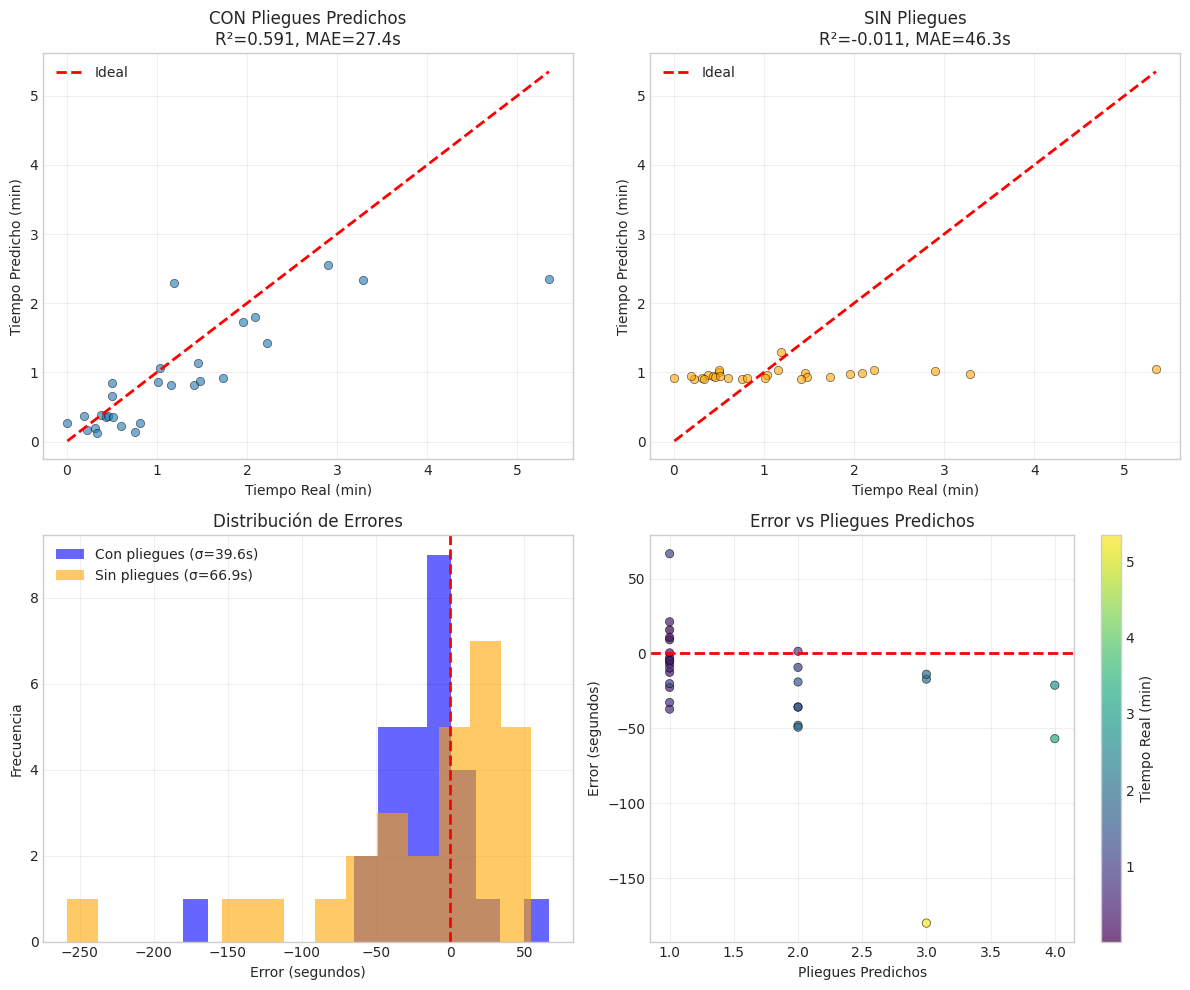


  Guardado: comparativa_pliegues_predichos.png

RESUMEN: MODELO DOS ETAPAS

  ETAPA 1: Predicción de pliegues
    - Features: área, AR, peso, TIEMPO, espesor, material
    - R² (CV sintéticos): 0.916
    - Pliegues predichos: 1-4 (media: 1.5)

  ETAPA 2: Predicción de tiempo
    - Features: área, AR, peso, pliegues_pred, espesor, material
    - Calibración: Lineal (α=0.387, β=0.504)

  RESULTADOS EN TEST:
    ┌────────────────────────────┬──────────┬────────────┐
    │ Modelo                     │    R²    │  MAE (seg) │
    ├────────────────────────────┼──────────┼────────────┤
    │ CON pliegues predichos     │   0.591  │     27.4    │
    │ SIN pliegues               │  -0.011  │     46.3    │
    ├────────────────────────────┼──────────┼────────────┤
    │ MEJORA                     │ +0.601  │   +18.9    │
    └────────────────────────────┴──────────┴────────────┘



In [287]:
# -----------------------------------------------------------------------------
# ETAPA 2: PREDECIR TIEMPO USANDO PLIEGUES PREDICHOS
# -----------------------------------------------------------------------------

print("\n--- Etapa 2: Modelo de tiempo con pliegues predichos ---")

# Features para predecir tiempo (CON número de pliegues)
FEATURES_TIEMPO_SINT = ['part_area_mm2', 'part_weight_kg', 'bend_v3_num_bends']
FEATURES_TIEMPO_REAL = ['bounding_box_area_mm2', 'peso_kg', 'num_pliegues_pred']

# Preparar sintéticos
X_sint_tiempo = df_sint_filtrado[FEATURES_TIEMPO_SINT].values
X_sint_espesor_t = df_sint_filtrado['espesor_mm'].values.reshape(-1, 1)
X_sint_material_t = encoder.transform(df_sint_filtrado['tipo_material'].values.reshape(-1, 1))
X_sint_tiempo_full = np.hstack([X_sint_tiempo, X_sint_espesor_t, X_sint_material_t])
y_sint_tiempo = df_sint_filtrado[COL_TIEMPO_SINT_FINAL].values

# Limpiar sintéticos
mask_sint_tiempo = ~np.isnan(X_sint_tiempo_full).any(axis=1) & ~np.isnan(y_sint_tiempo) & (y_sint_tiempo > 0)
X_sint_tiempo_full = X_sint_tiempo_full[mask_sint_tiempo]
y_sint_tiempo = y_sint_tiempo[mask_sint_tiempo]

# Preparar reales (con pliegues predichos)
X_real_tiempo = df_real_clean_filtered[FEATURES_TIEMPO_REAL].values
X_real_espesor_t = df_real_clean_filtered['espesor_mm'].values.reshape(-1, 1)
X_real_material_t = encoder.transform(df_real_clean_filtered['tipo_material'].values.reshape(-1, 1))
X_real_tiempo_full = np.hstack([X_real_tiempo, X_real_espesor_t, X_real_material_t])
y_real_tiempo = df_real_clean_filtered[COL_TIEMPO_REAL].values

# Limpiar reales
mask_real_tiempo = ~np.isnan(X_real_tiempo_full).any(axis=1) & ~np.isnan(y_real_tiempo) & (y_real_tiempo > 0)
X_real_tiempo_full = X_real_tiempo_full[mask_real_tiempo]
y_real_tiempo = y_real_tiempo[mask_real_tiempo]
df_real_evaluacion = df_real_clean_filtered[mask_real_tiempo].copy()

print(f"  Datos sintéticos: {X_sint_tiempo_full.shape}")
print(f"  Datos reales: {X_real_tiempo_full.shape}")
print(f"  Features: {FEATURES_TIEMPO_SINT}")

# -----------------------------------------------------------------------------
# ETAPA 2b: SPLIT, ENTRENAR, CALIBRAR Y EVALUAR
# -----------------------------------------------------------------------------

print("\n--- Etapa 2b: Entrenar, calibrar y evaluar ---")

# Split calibración/test
X_real_cal, X_real_test, y_real_cal, y_real_test, idx_cal, idx_test = train_test_split(
    X_real_tiempo_full, y_real_tiempo, np.arange(len(y_real_tiempo)),
    test_size=0.5, 
    random_state=RANDOM_STATE
)

print(f"  Calibración: {len(X_real_cal)}, Test: {len(X_real_test)}")

# Entrenar modelo con sintéticos
modelo_tiempo = Ridge(alpha=1.0)
modelo_tiempo.fit(X_sint_tiempo_full, y_sint_tiempo)

# Calibrar con reales
y_pred_cal_raw = modelo_tiempo.predict(X_real_cal)
factor_cal = np.mean(y_real_cal) / np.mean(y_pred_cal_raw) if np.mean(y_pred_cal_raw) > 0 else 1.0
alpha_cal, beta_cal = calibrar_lineal_positivo(y_pred_cal_raw, y_real_cal)

print(f"\n  Calibración:")
print(f"    Factor: {factor_cal:.4f}")
print(f"    Lineal: alpha={alpha_cal:.4f}, beta={beta_cal:.4f}")

# Evaluar en test
y_pred_test_raw = modelo_tiempo.predict(X_real_test)
y_pred_test_factor = y_pred_test_raw * factor_cal
y_pred_test_lineal = alpha_cal * y_pred_test_raw + beta_cal

# Métricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def calcular_metricas(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return r2, mae, rmse, mape

r2_raw, mae_raw, rmse_raw, mape_raw = calcular_metricas(y_real_test, y_pred_test_raw)
r2_factor, mae_factor, rmse_factor, mape_factor = calcular_metricas(y_real_test, y_pred_test_factor)
r2_lineal, mae_lineal, rmse_lineal, mape_lineal = calcular_metricas(y_real_test, y_pred_test_lineal)

print(f"\n  === RESULTADOS EN TEST ===")
print(f"\n  {'Calibración':<20} {'R²':>8} {'MAE(seg)':>10} {'RMSE(seg)':>10} {'MAPE(%)':>10}")
print(f"  {'-'*60}")
print(f"  {'Sin calibrar':<20} {r2_raw:>8.3f} {mae_raw*60:>10.1f} {rmse_raw*60:>10.1f} {mape_raw:>10.1f}")
print(f"  {'Factor':<20} {r2_factor:>8.3f} {mae_factor*60:>10.1f} {rmse_factor*60:>10.1f} {mape_factor:>10.1f}")
print(f"  {'Lineal':<20} {r2_lineal:>8.3f} {mae_lineal*60:>10.1f} {rmse_lineal*60:>10.1f} {mape_lineal:>10.1f}")

# Mejor calibración
mejor_cal = 'Lineal' if r2_lineal >= r2_factor else 'Factor'
mejor_r2 = max(r2_lineal, r2_factor)
mejor_mae = min(mae_lineal, mae_factor) * 60

print(f"\n  Mejor: {mejor_cal} (R²={mejor_r2:.3f}, MAE={mejor_mae:.1f} seg)")

# -----------------------------------------------------------------------------
# ETAPA 3: COMPARATIVA CON MODELO SIN PLIEGUES
# -----------------------------------------------------------------------------

print("\n" + "="*70)
print("COMPARATIVA: CON vs SIN PLIEGUES PREDICHOS")
print("="*70)

# Modelo SIN pliegues
FEATURES_SIN_PLIEGUES_SINT = ['part_area_mm2', 'aspect_ratio', 'part_weight_kg']
FEATURES_SIN_PLIEGUES_REAL = ['bounding_box_area_mm2', 'aspect_ratio', 'peso_kg']

X_sint_sin = df_sint_filtrado[FEATURES_SIN_PLIEGUES_SINT].values
X_sint_sin_full = np.hstack([X_sint_sin,
                              df_sint_filtrado['espesor_mm'].values.reshape(-1, 1),
                              encoder.transform(df_sint_filtrado['tipo_material'].values.reshape(-1, 1))])
X_sint_sin_full = X_sint_sin_full[mask_sint_tiempo]

X_real_sin = df_real_clean_filtered[FEATURES_SIN_PLIEGUES_REAL].values
X_real_sin_full = np.hstack([X_real_sin,
                              df_real_clean_filtered['espesor_mm'].values.reshape(-1, 1),
                              encoder.transform(df_real_clean_filtered['tipo_material'].values.reshape(-1, 1))])
X_real_sin_full = X_real_sin_full[mask_real_tiempo]

# Mismo split
X_real_sin_cal = X_real_sin_full[idx_cal]
X_real_sin_test = X_real_sin_full[idx_test]

# Entrenar sin pliegues
modelo_sin = Ridge(alpha=1.0)
modelo_sin.fit(X_sint_sin_full, y_sint_tiempo)

# Calibrar sin pliegues
y_pred_sin_cal = modelo_sin.predict(X_real_sin_cal)
alpha_sin, beta_sin = calibrar_lineal_positivo(y_pred_sin_cal, y_real_cal)

# Evaluar sin pliegues
y_pred_sin_test = modelo_sin.predict(X_real_sin_test)
y_pred_sin_test_cal = alpha_sin * y_pred_sin_test + beta_sin

r2_sin, mae_sin, rmse_sin, mape_sin = calcular_metricas(y_real_test, y_pred_sin_test_cal)

# Tabla comparativa
print(f"\n  {'Modelo':<35} {'R²':>8} {'MAE(seg)':>10} {'MAPE(%)':>10}")
print(f"  {'-'*65}")
print(f"  {'Con pliegues predichos':<35} {mejor_r2:>8.3f} {mejor_mae:>10.1f} {min(mape_lineal, mape_factor):>10.1f}")
print(f"  {'Sin pliegues (solo geometría)':<35} {r2_sin:>8.3f} {mae_sin*60:>10.1f} {mape_sin:>10.1f}")
print(f"  {'-'*65}")

mejora_r2 = mejor_r2 - r2_sin
mejora_mae = mae_sin*60 - mejor_mae

print(f"  {'MEJORA por pliegues':<35} {mejora_r2:>+8.3f} {mejora_mae:>+10.1f}")

if mejora_r2 > 0:
    print(f"\n  ✓ Los pliegues predichos MEJORAN el modelo en {mejora_r2:.3f} R²")
else:
    print(f"\n  ✗ Los pliegues predichos NO mejoran el modelo ({mejora_r2:.3f} R²)")

# -----------------------------------------------------------------------------
# VISUALIZACIÓN
# -----------------------------------------------------------------------------

print("\n--- Visualización ---")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Predicción vs Real - Con pliegues
ax1 = axes[0, 0]
y_pred_mejor = y_pred_test_lineal if mejor_cal == 'Lineal' else y_pred_test_factor
ax1.scatter(y_real_test, y_pred_mejor, alpha=0.6, edgecolors='k', linewidth=0.5)
ax1.plot([y_real_test.min(), y_real_test.max()], 
         [y_real_test.min(), y_real_test.max()], 'r--', lw=2, label='Ideal')
ax1.set_xlabel('Tiempo Real (min)')
ax1.set_ylabel('Tiempo Predicho (min)')
ax1.set_title(f'CON Pliegues Predichos\nR²={mejor_r2:.3f}, MAE={mejor_mae:.1f}s')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Predicción vs Real - Sin pliegues
ax2 = axes[0, 1]
ax2.scatter(y_real_test, y_pred_sin_test_cal, alpha=0.6, edgecolors='k', linewidth=0.5, color='orange')
ax2.plot([y_real_test.min(), y_real_test.max()], 
         [y_real_test.min(), y_real_test.max()], 'r--', lw=2, label='Ideal')
ax2.set_xlabel('Tiempo Real (min)')
ax2.set_ylabel('Tiempo Predicho (min)')
ax2.set_title(f'SIN Pliegues\nR²={r2_sin:.3f}, MAE={mae_sin*60:.1f}s')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribución de errores
ax3 = axes[1, 0]
error_con = (y_pred_mejor - y_real_test) * 60  # en segundos
error_sin = (y_pred_sin_test_cal - y_real_test) * 60
ax3.hist(error_con, bins=15, alpha=0.6, label=f'Con pliegues (σ={np.std(error_con):.1f}s)', color='blue')
ax3.hist(error_sin, bins=15, alpha=0.6, label=f'Sin pliegues (σ={np.std(error_sin):.1f}s)', color='orange')
ax3.axvline(0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Error (segundos)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de Errores')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Pliegues predichos vs Error
ax4 = axes[1, 1]
pliegues_test = df_real_evaluacion.iloc[idx_test]['num_pliegues_pred'].values
scatter = ax4.scatter(pliegues_test, error_con, c=y_real_test, cmap='viridis', 
                       alpha=0.7, edgecolors='k', linewidth=0.5)
ax4.axhline(0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Pliegues Predichos')
ax4.set_ylabel('Error (segundos)')
ax4.set_title('Error vs Pliegues Predichos')
plt.colorbar(scatter, ax=ax4, label='Tiempo Real (min)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparativa_pliegues_predichos.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n  Guardado: comparativa_pliegues_predichos.png")

# -----------------------------------------------------------------------------
# RESUMEN FINAL
# -----------------------------------------------------------------------------

print("\n" + "="*70)
print("RESUMEN: MODELO DOS ETAPAS")
print("="*70)

print(f"""
  ETAPA 1: Predicción de pliegues
    - Features: área, AR, peso, TIEMPO, espesor, material
    - R² (CV sintéticos): {cv_scores_pliegues.mean():.3f}
    - Pliegues predichos: {pliegues_predichos_round.min()}-{pliegues_predichos_round.max()} (media: {pliegues_predichos_round.mean():.1f})

  ETAPA 2: Predicción de tiempo
    - Features: área, AR, peso, pliegues_pred, espesor, material
    - Calibración: {mejor_cal} (α={alpha_cal:.3f}, β={beta_cal:.3f})
    
  RESULTADOS EN TEST:
    ┌────────────────────────────┬──────────┬────────────┐
    │ Modelo                     │    R²    │  MAE (seg) │
    ├────────────────────────────┼──────────┼────────────┤
    │ CON pliegues predichos     │  {mejor_r2:>6.3f}  │   {mejor_mae:>6.1f}    │
    │ SIN pliegues               │  {r2_sin:>6.3f}  │   {mae_sin*60:>6.1f}    │
    ├────────────────────────────┼──────────┼────────────┤
    │ MEJORA                     │ {mejora_r2:>+6.3f}  │  {mejora_mae:>+6.1f}    │
    └────────────────────────────┴──────────┴────────────┘
""")